In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import gc
import cv2

from time import time
import matplotlib as mpl

import hsilib as hl
hl = reload(hl)
import tifffile as tfl
from pathlib import Path

In [3]:
def get_rayleigh_scattering(HSI):
    height, width, bands = HSI.shape
    rayleigh_sig = np.zeros(shape = bands, dtype = HSI.dtype)
    for i in range(bands):
        layer = HSI[..., i]
        rayleigh_sig[i] = layer[layer > 0].min()
        
    return rayleigh_sig

def cv2_save(image, path):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    result = cv2.imwrite(path, image)
    return result

In [41]:
hsi_tif = tfl.TiffFile(r'C:\Users\konst\jupyter_notebook\HSI\data envil\indian pine\19920612_AVIRIS_IndianPine_Site3.tif')
mask_tif = tfl.TiffFile(r'C:\Users\konst\jupyter_notebook\HSI\data envil\indian pine\19920612_AVIRIS_IndianPine_Site3_gr.tif')
mask = mask_tif.asarray().copy()

In [17]:
reference_coords = np.array(((107,  38),  #0
                             (130, 100),  #1
                             (80,   13),  #2
                             (16,   47),  #3
                             (5,     7),  #4
                             (50,   85),  #5
                             (80,   80),  #6
                             (50,  130)), #7
                             dtype = int)

name_reference_ru = ("класс 1", "класс 2", "класс 3", "класс 4", "класс 5", "класс 6", "класс 7", "класс 8")

colors_class = np.array(((100, 172, 254), (138,  63,  45), (254,   1, 250), (253, 254,   2),
                         (254,  88,   0), (159,  77, 157), (  2,  27, 240), ( 11, 254,   6)))

colors_class = np.float32(colors_class / 255.)

класс 1


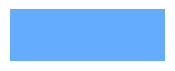

класс 2


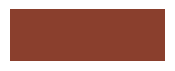

класс 3


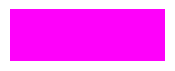

класс 4


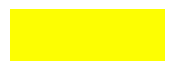

класс 5


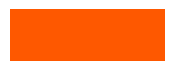

класс 6


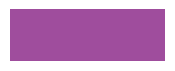

класс 7


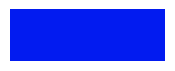

класс 8


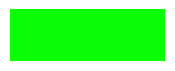

In [18]:
for i in range(colors_class.shape[0]):
    color_pat = np.zeros(shape = (32, 96, 3), dtype = np.uint8)
    color_pat[:, :] = np.uint8(colors_class[i] * 255)
    #cv2_save(color_pat, r'C:\Users\konst\Desktop\c\\' + str(i + 1) + '.png')
    print(name_reference_ru[i])
    hl.show(color_pat, figsize = (2, 2))

-----------------------

(145, 145, 220)


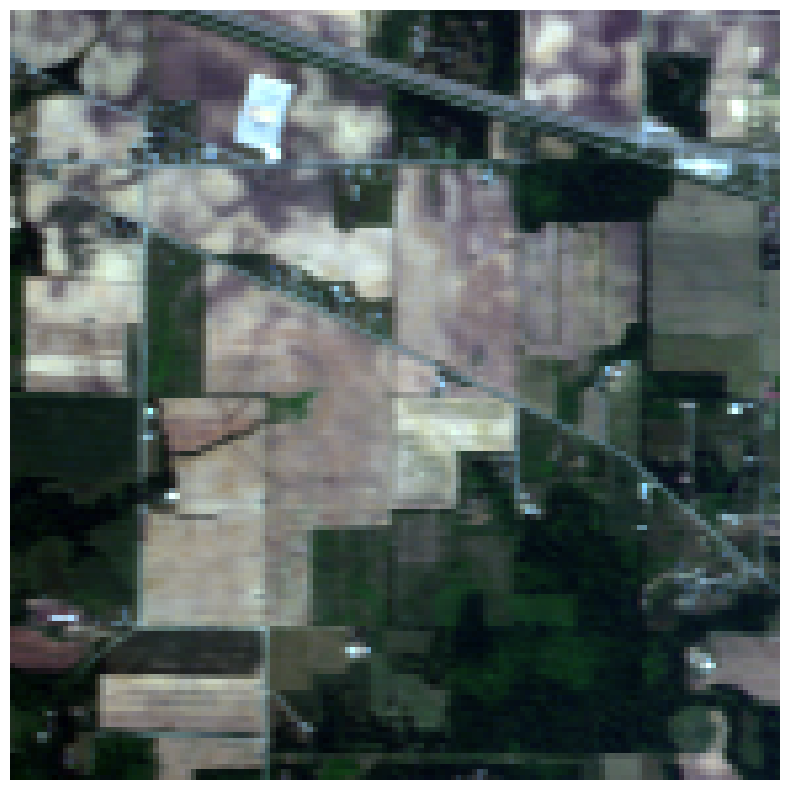

In [10]:
hsi = hsi_tif.asarray().copy()
hsi = np.rollaxis(hsi, 0, 3)
print(hsi.shape)

color_image = hl.HSI_to_RGB(hsi, (29, 16, 8))
hl.show(color_image, figsize = (10, 10))

In [11]:
cv2_save(color_image, r'C:\Users\konst\jupyter_notebook\HSI\data envil\indian pine\indian pine.png')

True

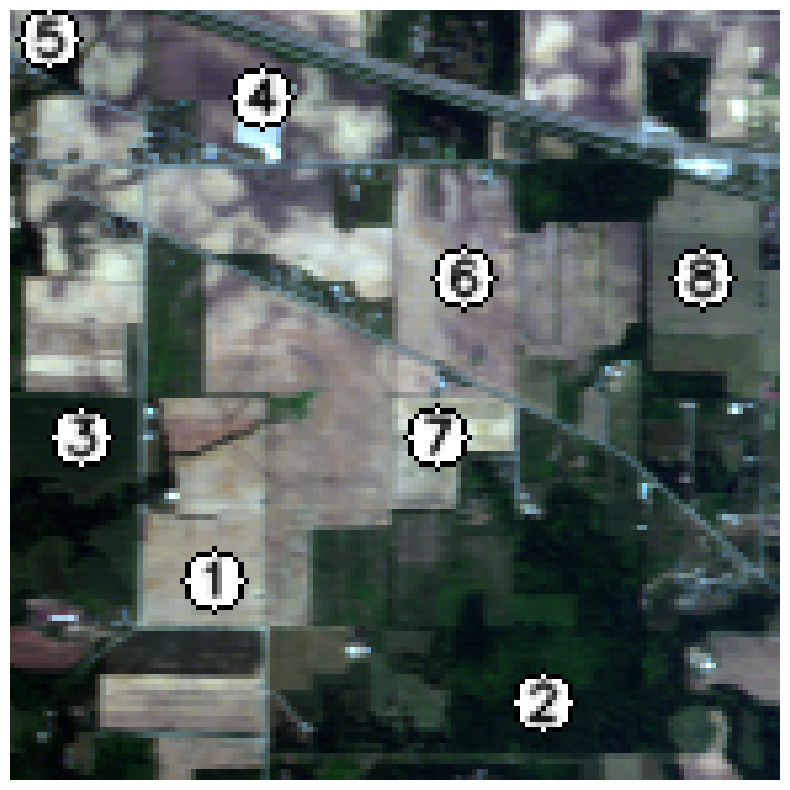

In [21]:
image = color_image.copy()
scale = 0.3

for i in range(len(reference_coords)):
    xy = (reference_coords[i, 1], reference_coords[i, 0])
    image = cv2.circle(image, xy, int(21 * scale), (255, 255, 255), -1)
    image = cv2.circle(image, xy, int(21 * scale), (0, 0, 0), int(2 * scale))
    if i < 9:
        xy_text = (reference_coords[i, 1] - int(10 * scale), reference_coords[i, 0] + int(10 * scale))
        image = cv2.putText(image, str(i + 1), xy_text, cv2.FONT_HERSHEY_SIMPLEX, 1 * scale, (0, 0, 0), int(1 * scale), cv2.LINE_AA)
    else:
        xy_text = (reference_coords[i, 1] - int(22 * scale), reference_coords[i, 0] + int(10 * scale))
        image = cv2.putText(image, str(i + 1), xy_text, cv2.FONT_HERSHEY_SIMPLEX, 1 * scale, (0, 0, 0), int(2 * scale), cv2.LINE_AA)
        
plt.figure(figsize = (10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

In [22]:
rayleigh_scattering = get_rayleigh_scattering(hsi)
hsi -= rayleigh_scattering
hsi[hsi < 0] = 0

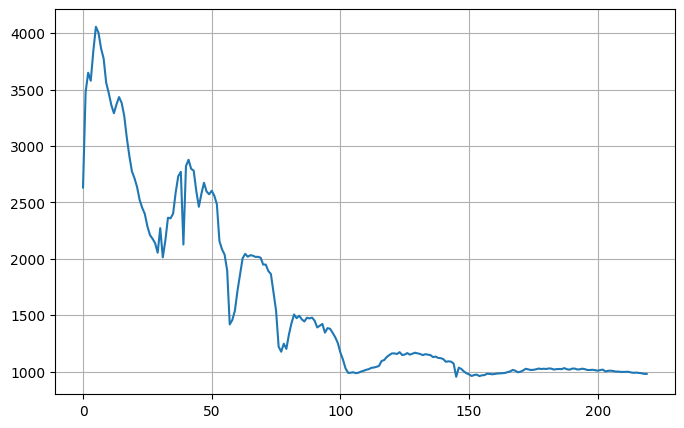

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(rayleigh_scattering)
plt.grid()
plt.show()

In [24]:
hsi = np.concatenate((hsi[..., :100], hsi[..., 110:136], hsi[..., 152:201]), axis = 2)
height, width, bands = hsi.shape
print(height, width, bands)

145 145 175


In [25]:
hsi_reference = hl.calc_ref(reference_coords, hsi, 1)

In [26]:
imf_reference = hl.EMD(hsi_reference, 4)

обработано 8 пикселей из 8

In [27]:
imfs = hl.EMD(hsi, 4)

обработано 21025 пикселей из 21025

In [28]:
def ANGLE(vector1, vector2):
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)

    return np.abs(np.dot(unit_vector1, unit_vector2) - 1)

def mul_cos_angles(matrix, vector):
    unit_vector = vector / np.linalg.norm(vector)
    dot = np.zeros(shape = matrix.shape[:2])
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            
            norm = np.linalg.norm(matrix[i, j])
            if norm != 0:
                unit_matrix = matrix[i, j] / np.linalg.norm(matrix[i, j])
                dot[i, j] = np.dot(unit_matrix, unit_vector)
                
    return np.abs(dot - 1)

def EVKLID(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

def show_corr_matrix(corr_matrix, label_axis, title, path = None, m = 'a'):    
    fig, ax = plt.subplots(figsize = (7, 7))
    im = ax.imshow(corr_matrix)

    ax.set_xticks(np.arange(len(label_axis)), labels=label_axis, fontsize = 12)
    ax.set_yticks(np.arange(len(label_axis)), labels=label_axis, fontsize = 12)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    for i in range(len(label_axis)):
        for j in range(len(label_axis)):
            if m == 'e':
                text = ax.text(j, i, int(corr_matrix[i, j]), ha="center", va="center", color="w", fontsize = 16)
            elif m == 'a':       
                text = ax.text(j, i, str(corr_matrix[i, j])[0:4], ha="center", va="center", color="w", fontsize = 16)
    
    #ax.set_title(title, fontsize = 16)
    fig.tight_layout()
    
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close()

def do_corr_matrix(vector, metric):
    len_vec = vector.shape[0]
    
    corr_matrix = np.zeros(shape = (len_vec, len_vec), dtype = float)
    
    for j in range(len_vec):
        for k in range(len_vec):
            if j > k:
                continue
            
            correlation = metric(vector[j], vector[k])
            
            corr_matrix[j, k] = correlation
            corr_matrix[k, j] = correlation
            
    return corr_matrix

def do_clust_lite(imf_reference, name_reference, path, m):
    main_num_classes = imf_reference.shape[0]
    num_class_power = -1
    
#############################################################
    class_stat = dict()
    for i in range(len(name_reference)):
        class_stat[name_reference[i]] = [main_num_classes - 1, 0, 0]
        
#################################################################    
    for nc in range(main_num_classes - 1):
        tmp = 0
        max_class_power = 0
        num_class_power = -1
        num_classes, _ = imf_reference.shape
        correlation_inside = 0
#################################################################
            
        if num_classes > 2:
            if m == 'e':
                corr_matrix = do_corr_matrix(imf_reference, EVKLID)
            elif m == 'a':
                corr_matrix = do_corr_matrix(imf_reference, ANGLE)
            
            for k in range(num_classes):
                other_modul = 0.0
                
                for j in range(num_classes):
                    if j == k:
                        continue
                    other_stat_class = np.delete(corr_matrix[j], (k, j))
                    other_stat_class = other_stat_class.mean()
                    other_modul = other_modul + other_stat_class ** 2
                    
                
                class_power = np.sqrt(np.sum(corr_matrix[k] ** 2)) / np.sqrt(other_modul)
                if class_power > max_class_power:
                    max_class_power = class_power
                    num_class_power = k
                    tmp = corr_matrix[k]
                    correlation_inside = np.sqrt(np.sum(corr_matrix[k] ** 2))
                    
            
            class_stat[name_reference[num_class_power]][0] = nc
            class_stat[name_reference[num_class_power]][1] = correlation_inside
            class_stat[name_reference[num_class_power]][2] = np.min(tmp[tmp != 0])
                        
        else:
            if m =='e':
                corr_two_classes = EVKLID(imf_reference[0], imf_reference[1])
            if m =='a':
                corr_two_classes = ANGLE(imf_reference[0], imf_reference[1])
            corr_matrix = np.array(((0, corr_two_classes), (corr_two_classes, 0)), dtype = float)
            
            class_stat[name_reference[num_class_power]][0] = nc
            class_stat[name_reference[num_class_power]][1] = corr_two_classes
            class_stat[name_reference[num_class_power]][2] = corr_two_classes
            
            class_stat[name_reference[num_class_power + 1]][0] = main_num_classes - 1
            class_stat[name_reference[num_class_power + 1]][1] = corr_two_classes
            class_stat[name_reference[num_class_power + 1]][2] = corr_two_classes
        
        print("\nclass_power", max_class_power, name_reference[num_class_power])
        
        if path is None:
            show_corr_matrix(corr_matrix, name_reference, "наисельнейший класс - " + name_reference[num_class_power], m = m)
        else:
            corr_path = path + '/cross-correlation-matrices/' + str(nc + 1) + "-" + name_reference[num_class_power] + "-cp-" + str(max_class_power)[:6] + ".png"
            show_corr_matrix(corr_matrix, name_reference, "наисельнейший класс - " + name_reference[num_class_power], corr_path, m = m)
    
        imf_reference = np.delete(imf_reference, num_class_power, axis = 0)
        name_reference = np.delete(name_reference, num_class_power)
    return class_stat

def do_class_mask(imf_data, imf_reference, class_stat, sorted_value_index, delta, path, m):

    class_mask = np.zeros(shape = (height, width), dtype = int)
    class_mask[:, :] = -1
    
    #arange = np.arange(imfs.shape[0])
    sort_name_reference = list(class_stat.keys())
    
    for i in range(len(sort_name_reference)):
    #################################################################
        name = sort_name_reference[i]
        print("name", name)
        
        print("imf_data.shape", imf_data.shape)
        
    #################################################################    
        n_class = sorted_value_index[i]
        print("n_class", n_class)
        
        reference = imf_reference[n_class]
        print("reference", reference.shape)
        
    #################################################################
        if m == 'e':
            tmp_class_mask = np.linalg.norm(imf_data - reference, axis = 2)
        elif m == 'a':
            tmp_class_mask = mul_cos_angles(imf_data, reference)   #for ANGLE
    
        std_class_corr = class_stat[name][1]
        min_class_corr = class_stat[name][2]
        
        if m == 'a':
            tmp_class_mask[tmp_class_mask > 1 - delta] = 0           #for ANGLE
        if m == 'e':
            tmp_class_mask[tmp_class_mask > min_class_corr * delta] = 0
        class_mask[(tmp_class_mask != 0) & (class_mask == -1)] = n_class
        print("min_class_corr", min_class_corr)
        
        title = "класс №" + str(i + 1) + " - " + name
        plt.figure(figsize = (20, 8))
        plt.title(title, fontsize = 20)
        plt.imshow(tmp_class_mask)
        plt.colorbar(shrink = 0.3)
        plt.axis("off")
        plt.tight_layout()
        
        if path is None:
            plt.show()
        else:
            plt.savefig(path + '/inter-iteration-division-into-classes/' + title)
            plt.close()
        
        print('\n')
    
    del imf_data
    _ = gc.collect()
        
    return class_mask

In [29]:
def build_color_image(class_mask, colors_class, path):

    color_class = np.zeros(shape = (height, width, 3), dtype = np.uint8)
    for i in range(colors_class.shape[0]):
        color_class[class_mask == i] = np.uint8(colors_class[i] * 255)
    
    non_class_pix = np.zeros(shape = (height, width), dtype = bool)
    non_class_pix[class_mask == -1] = True
    sum_non_class_pix = np.sum(non_class_pix)
    pr = np.float16(sum_non_class_pix / (height * width) * 100)
    
    title = "Контрастная разметка классов. " + str(pr) + "% пикселей не поддались классификации."
    plt.figure(figsize = (20, 8))
    #plt.title(title, fontsize = 20)
    plt.imshow(color_class)
    plt.axis("off")
    plt.tight_layout()
    
    if path is None:
        plt.show()
    else:
        plt.savefig(path + '/' + title)
        plt.close()
        
    return color_class

In [30]:
def do_all(data, reference, name_reference, colors_class, delta, path = None, m = 'a'):
    
    if path is not None:
        Path(path + '/cross-correlation-matrices').mkdir(parents = True, exist_ok = True)
        Path(path + '/inter-iteration-division-into-classes').mkdir(parents = True, exist_ok = True)
    
    class_stat = do_clust_lite(reference, name_reference, path, m)
    
    sorted_value_index = np.array(list(class_stat.values()), dtype = float)
    sorted_value_index = np.array(sorted_value_index[:, 0], dtype = int)
    sorted_value_index = np.argsort(sorted_value_index)

    class_stat = {k: v for k, v in sorted(class_stat.items(), key = lambda item: item[1])}
    
    class_mask = do_class_mask(data, reference, class_stat, sorted_value_index, delta, path, m)
    
    color_class = build_color_image(class_mask, colors_class, path)
    
    return class_mask, color_class

# source


class_power 1.6379989286656966 класс 3


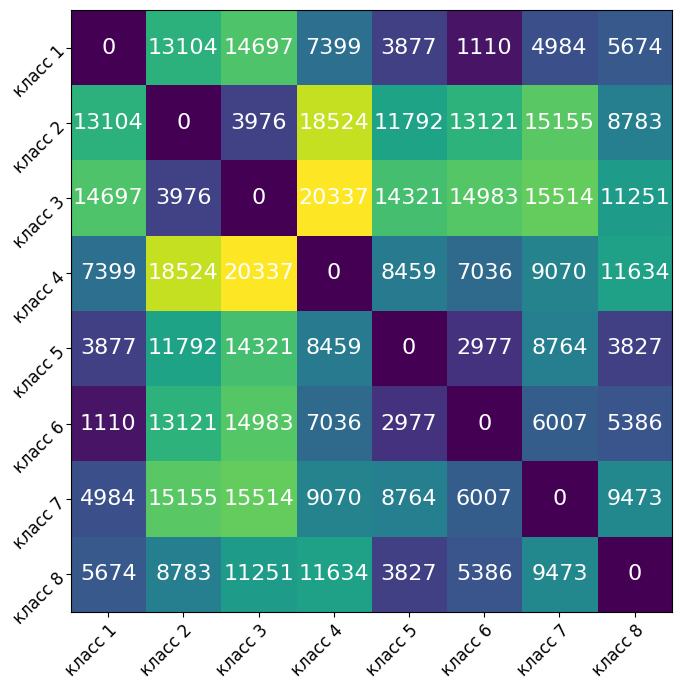


class_power 2.090578486370688 класс 2


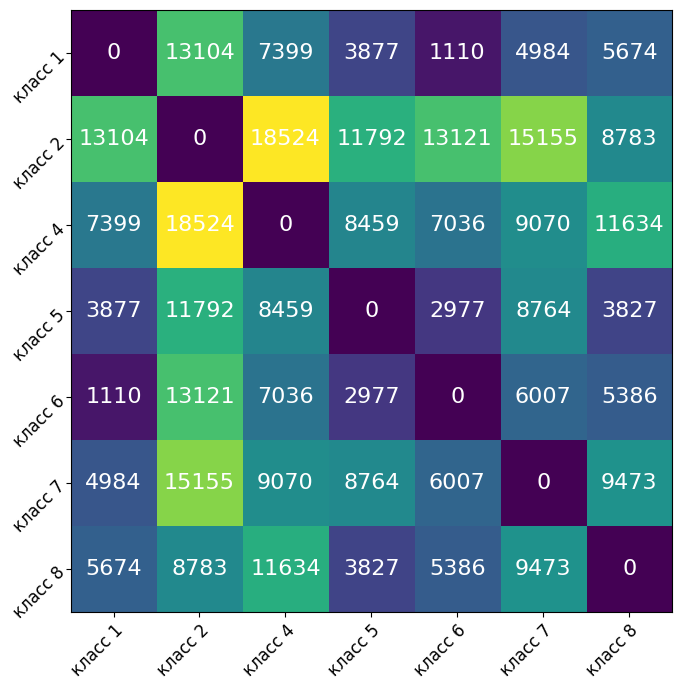


class_power 1.6506254035030739 класс 4


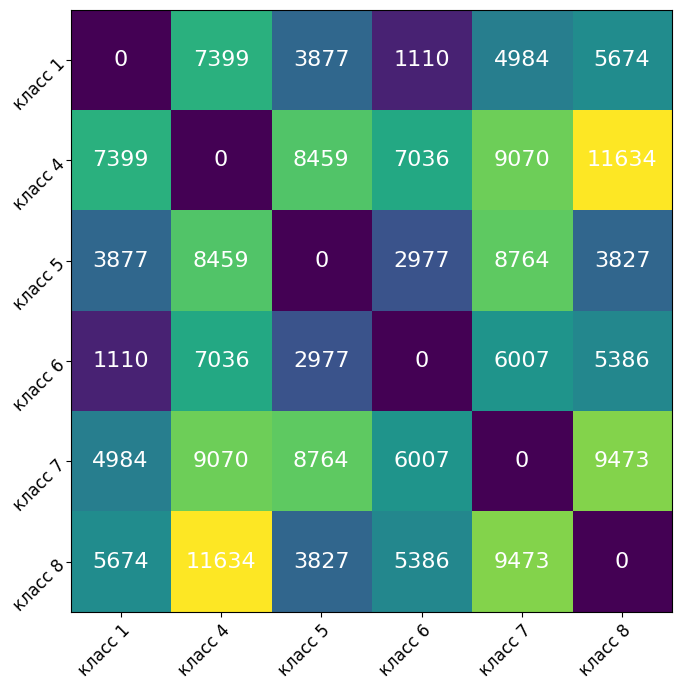


class_power 1.9486006222782637 класс 7


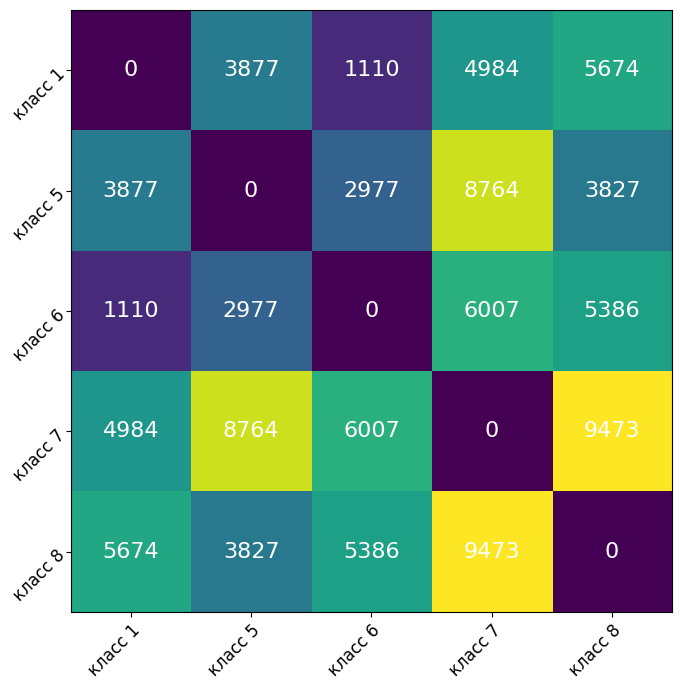


class_power 1.8508310548065228 класс 8


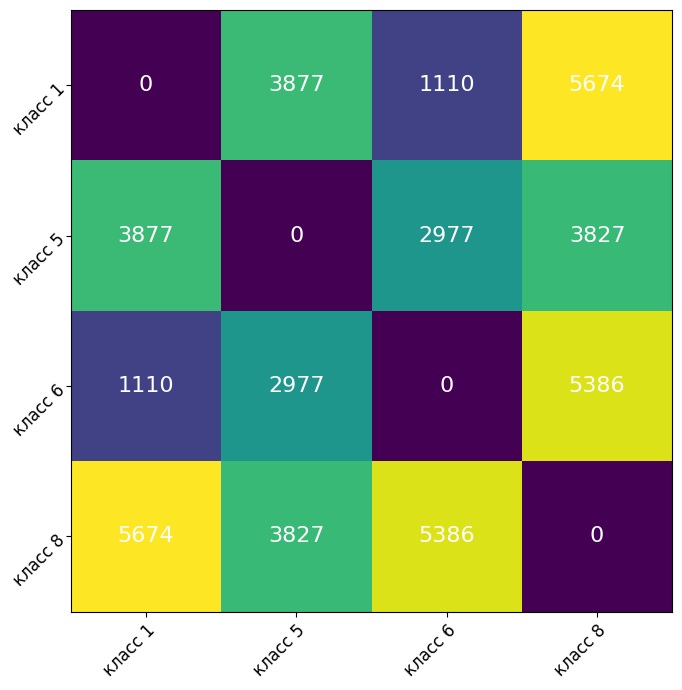


class_power 3.1129980642167894 класс 5


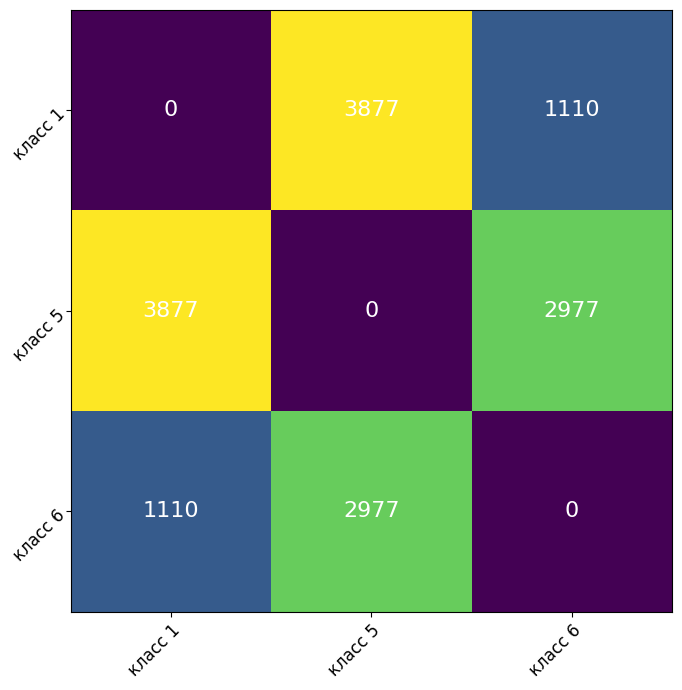


class_power 0 класс 6


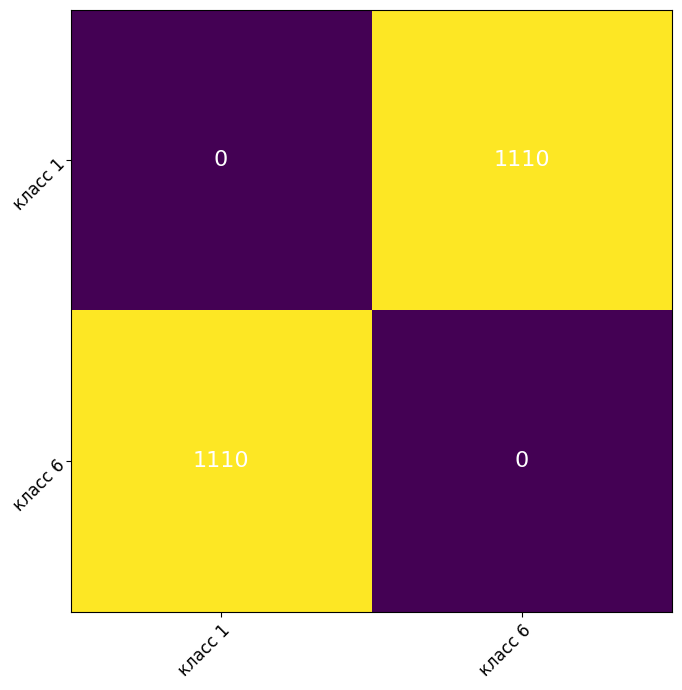

name класс 3
imf_data.shape (145, 145, 175)
n_class 2
reference (175,)
min_class_corr 3976.5107820801895


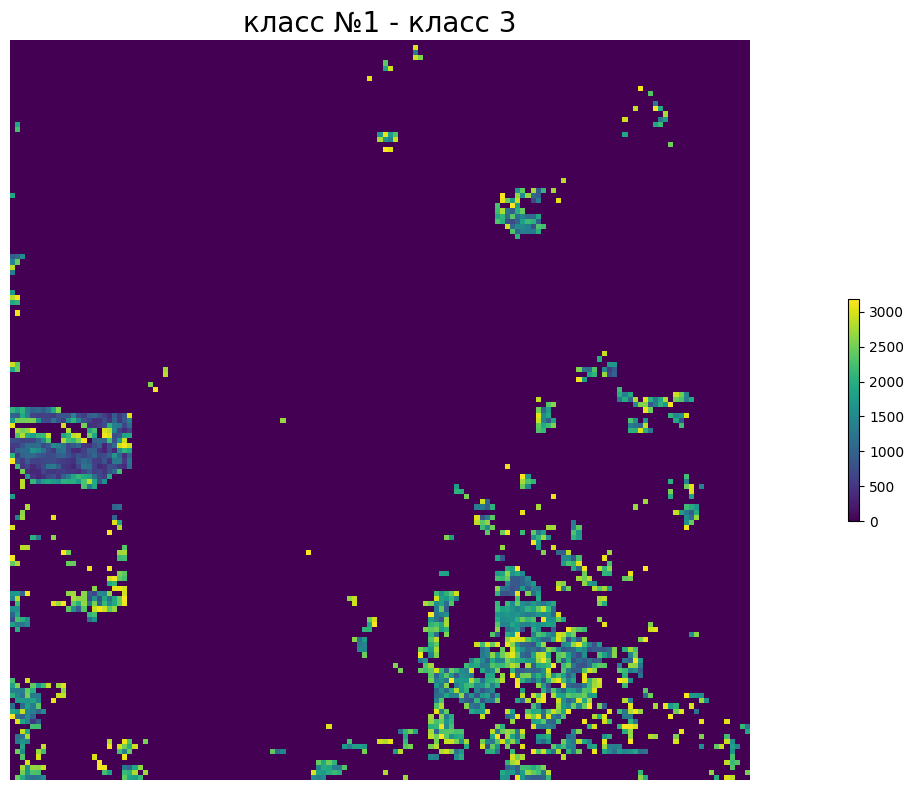



name класс 2
imf_data.shape (145, 145, 175)
n_class 1
reference (175,)
min_class_corr 8783.830201000017


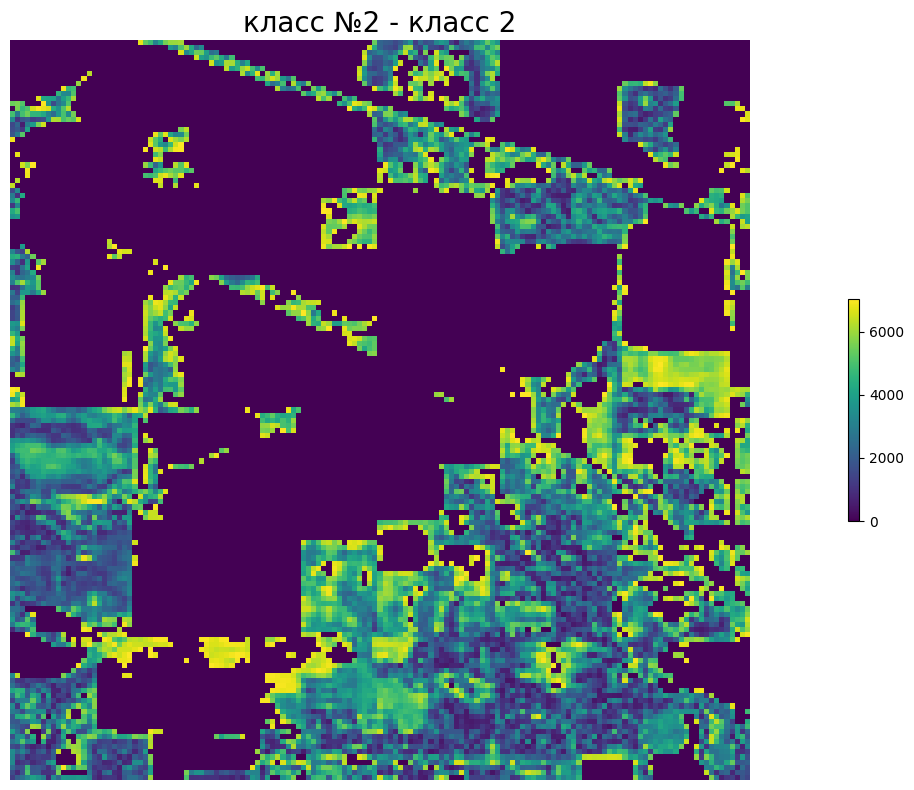



name класс 4
imf_data.shape (145, 145, 175)
n_class 3
reference (175,)
min_class_corr 7036.568197637254


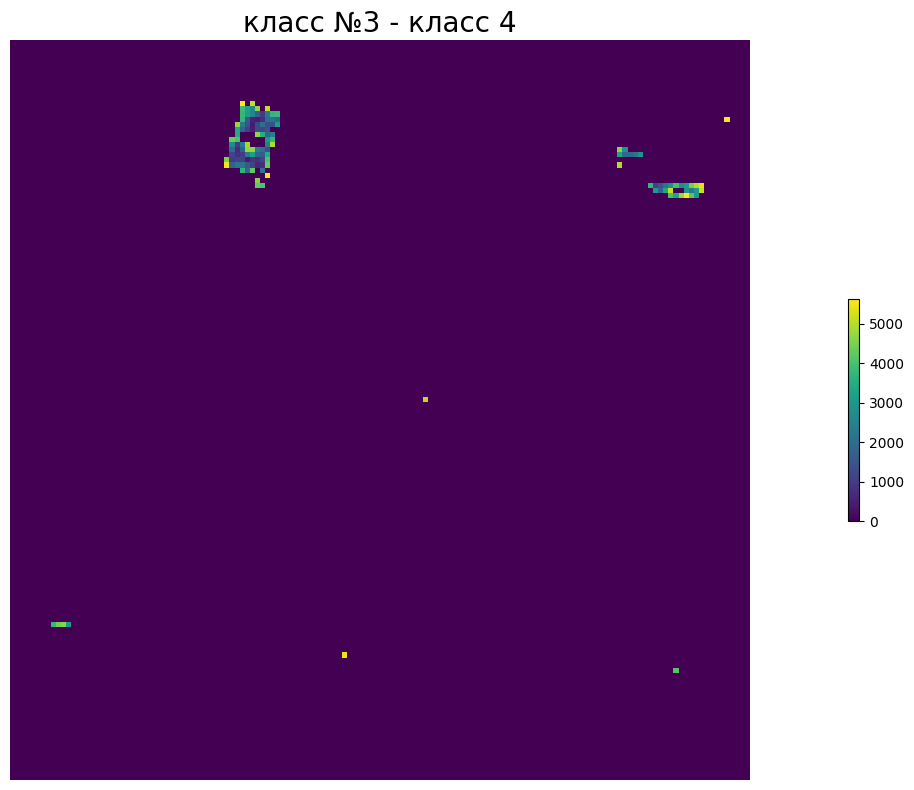



name класс 7
imf_data.shape (145, 145, 175)
n_class 6
reference (175,)
min_class_corr 4984.645022466495


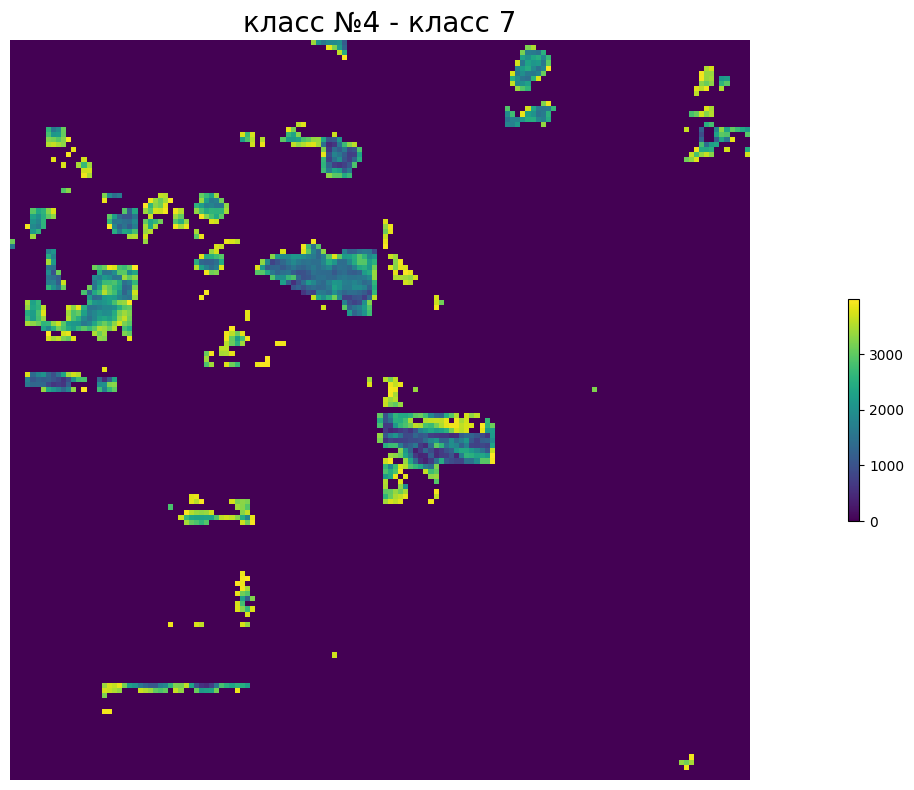



name класс 8
imf_data.shape (145, 145, 175)
n_class 7
reference (175,)
min_class_corr 3827.5595357877846


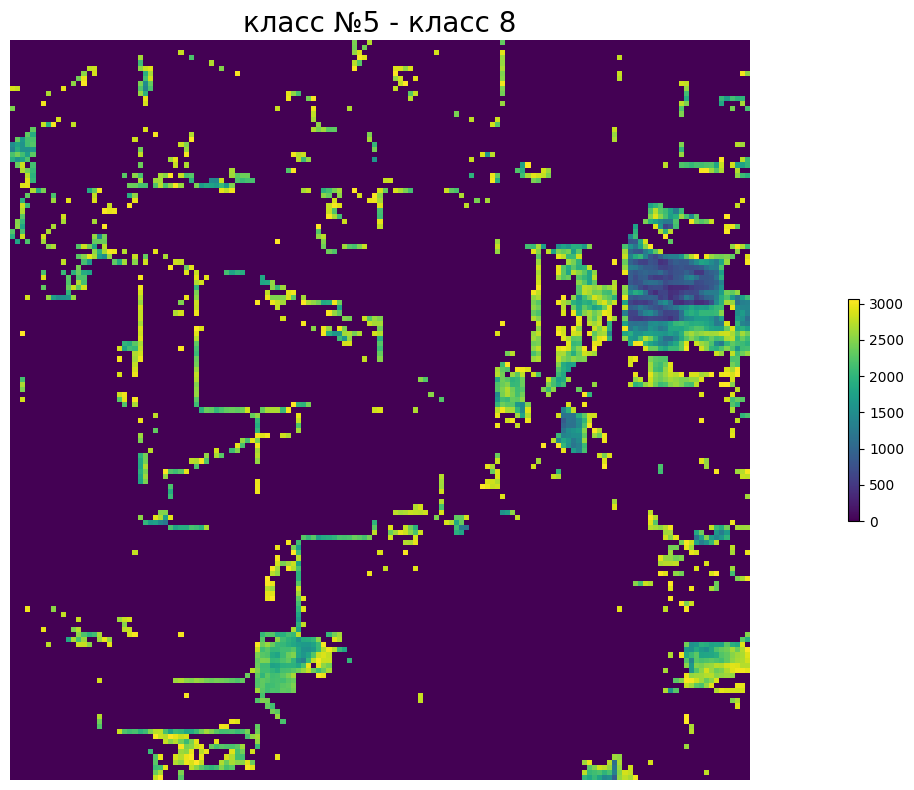



name класс 5
imf_data.shape (145, 145, 175)
n_class 4
reference (175,)
min_class_corr 2977.310027524846


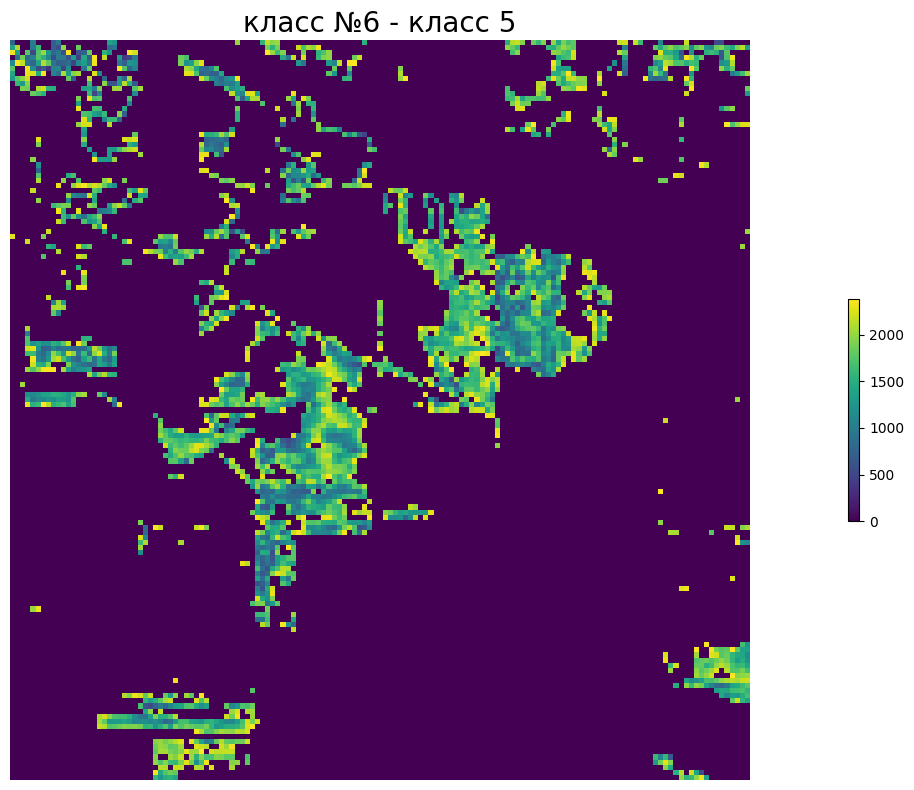



name класс 6
imf_data.shape (145, 145, 175)
n_class 5
reference (175,)
min_class_corr 1110.5084421110898


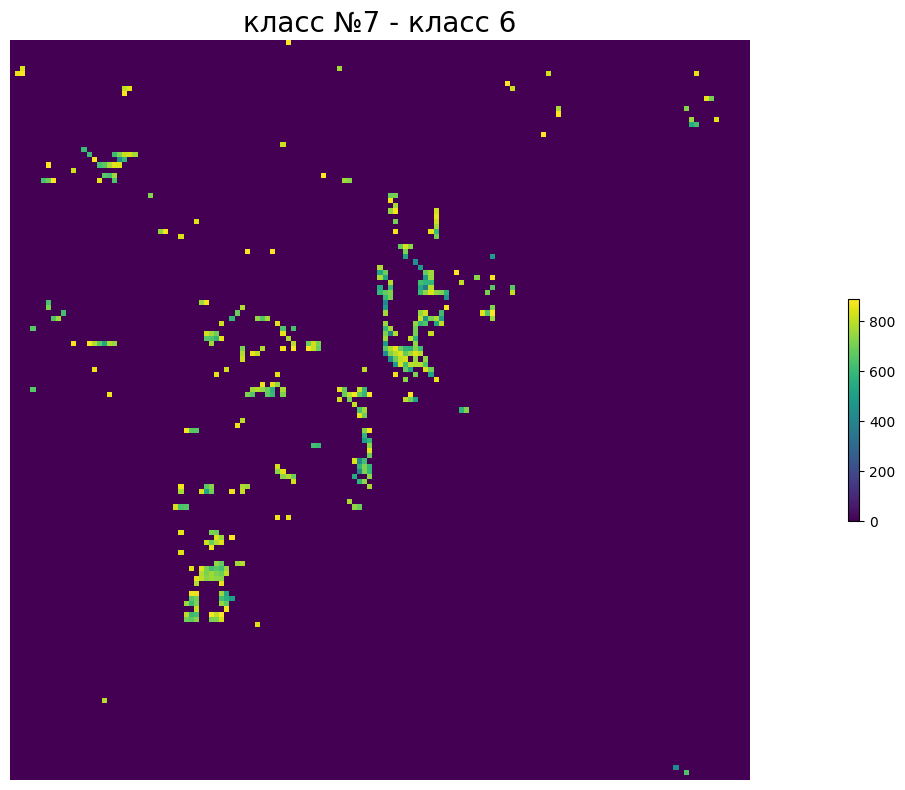



name класс 1
imf_data.shape (145, 145, 175)
n_class 0
reference (175,)
min_class_corr 1110.5084421110898


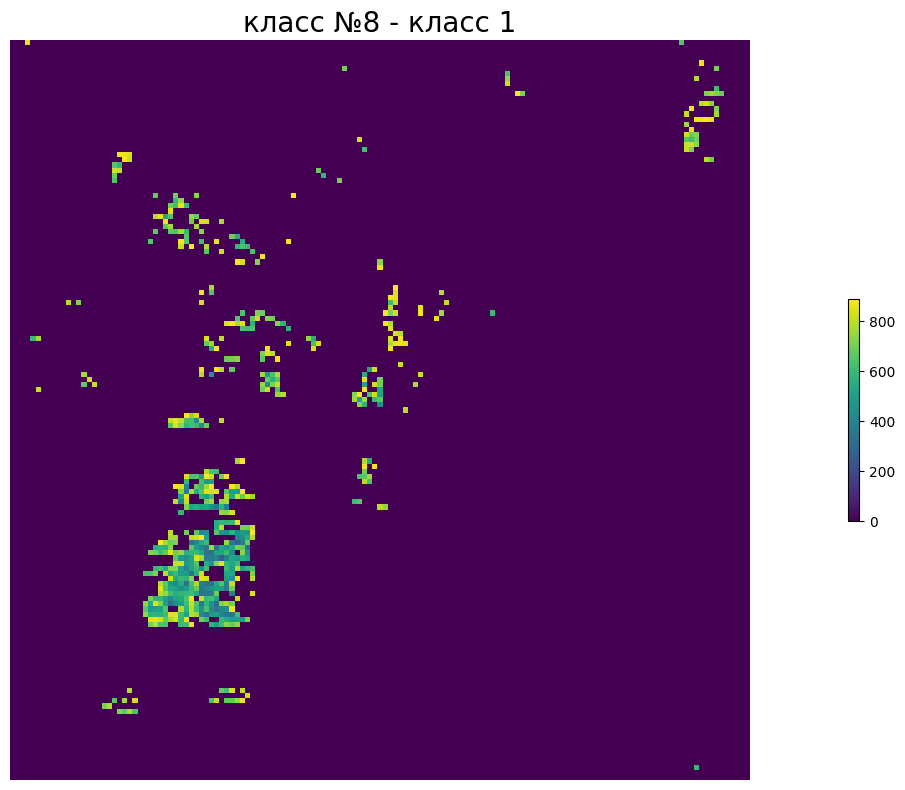

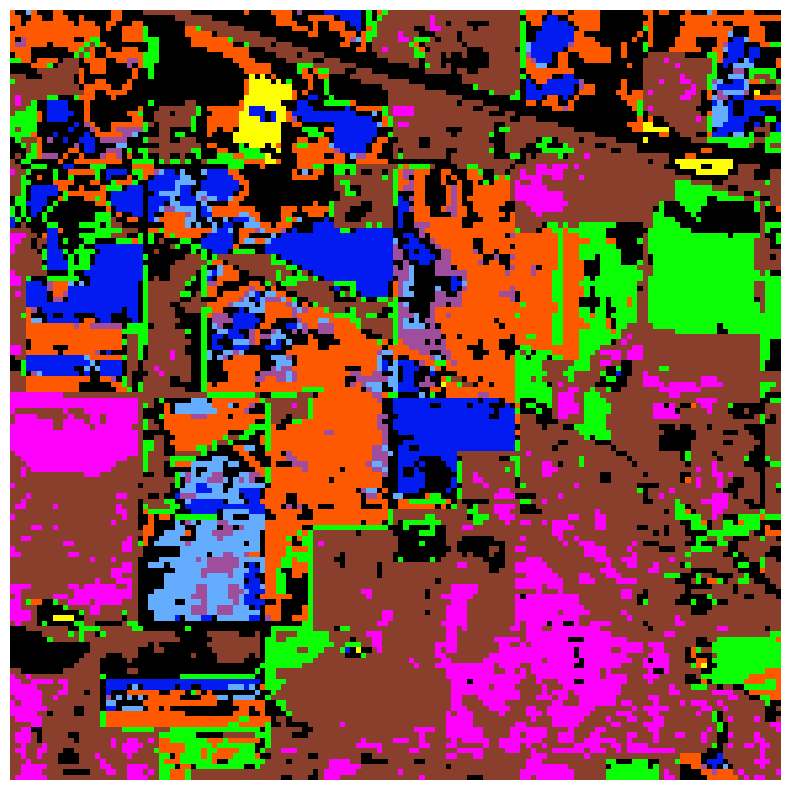

In [34]:
class_mask, color_class = do_all(hsi, hsi_reference, name_reference_ru, colors_class, delta = 0.8, path = None, m = 'e')

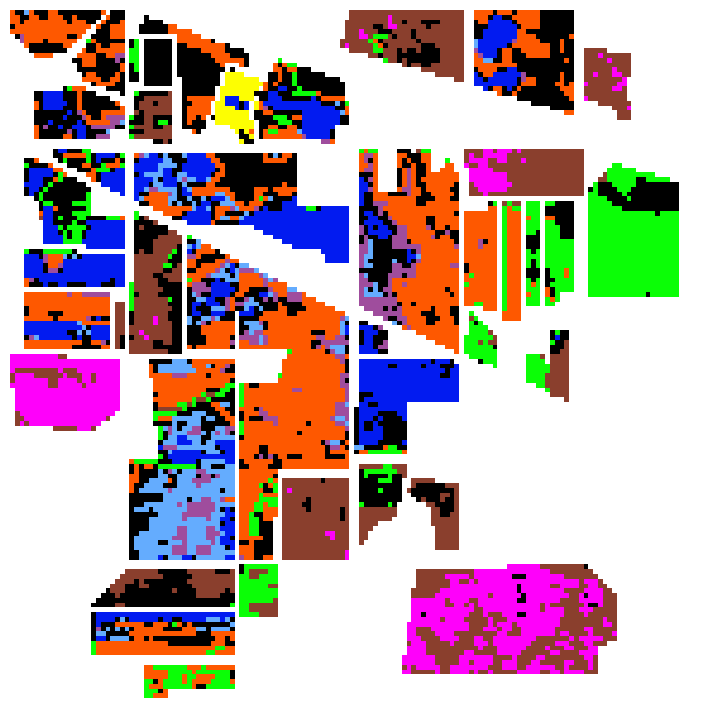

In [40]:
color_class[mask == 0] = 255
hl.show(color_class, figsize = (9, 9))

# imf + source

In [79]:
num_imf = 3

norm_hsi_reference = np.zeros(shape = hsi_reference.shape, dtype = float)
norms = np.linalg.norm(imf_reference[num_imf], axis = 1) / np.linalg.norm(hsi_reference, axis = 1)

for i in range(len(reference_coords)):
    norm_hsi_reference[i] = hsi_reference[i] * norms[i]

imf_con_src_reference = np.concatenate((imf_reference[num_imf], norm_hsi_reference), axis = 1)
imf_con_src_reference.shape

(8, 350)

In [80]:
imf = imfs[num_imf]

norm_hsi = np.linalg.norm(hsi, axis = 2)
norm_imf = np.linalg.norm(imf, axis = 2)

imf_con_src_data = np.zeros(shape = (height, width, bands * 2))

for h in range(height):
    for w in range(width):

        imf_con_src_data[h, w, :bands] = imf[h, w]
        imf_con_src_data[h, w, bands:] = hsi[h, w] * (norm_imf[h, w] / norm_hsi[h, w])
        
    if h % 100 == 0:
        print('\r', end = '')
        print(h, end = '')
        
imf_con_src_data = np.nan_to_num(imf_con_src_data, 0)

100


class_power 1.8740171538497872 класс 3


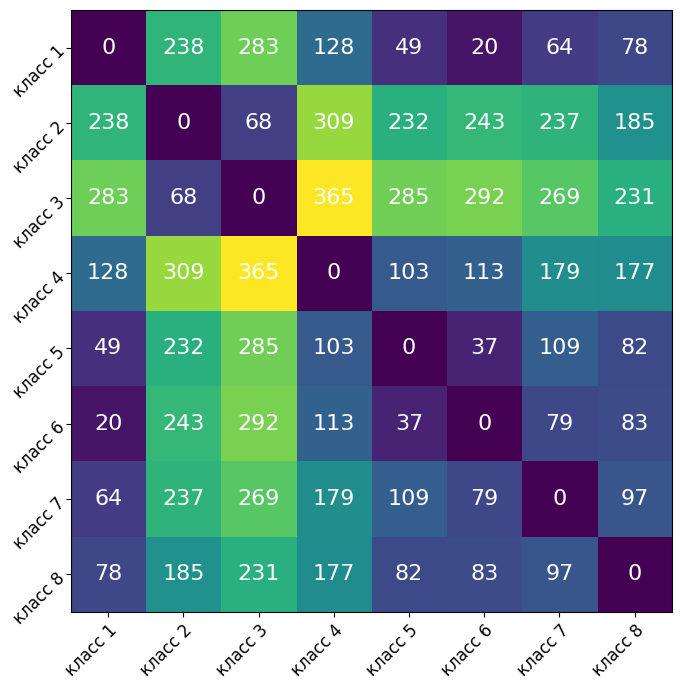


class_power 2.506241033526205 класс 2


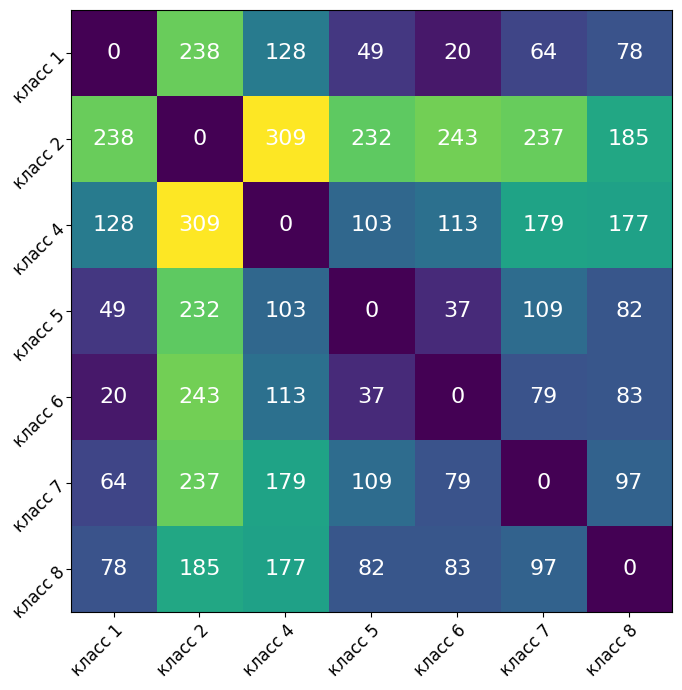


class_power 2.0113605392072205 класс 4


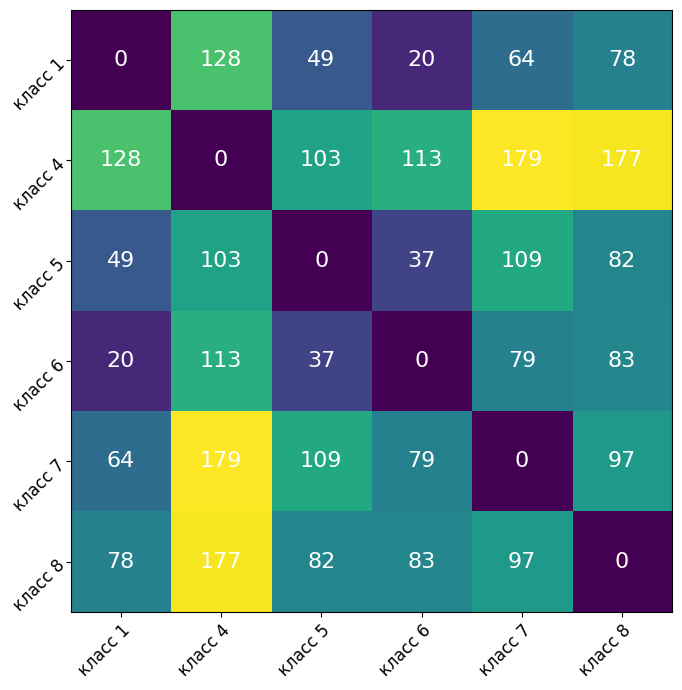


class_power 1.4833463496941448 класс 7


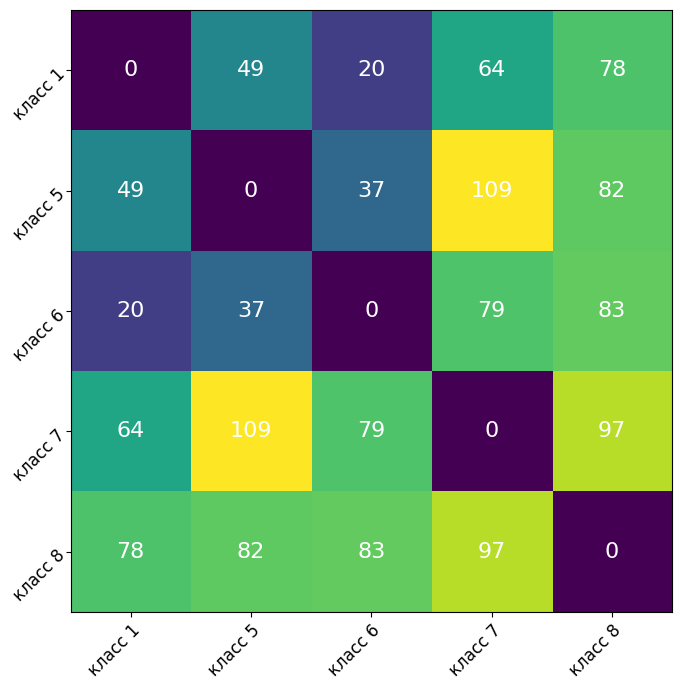


class_power 2.2477590858354723 класс 8


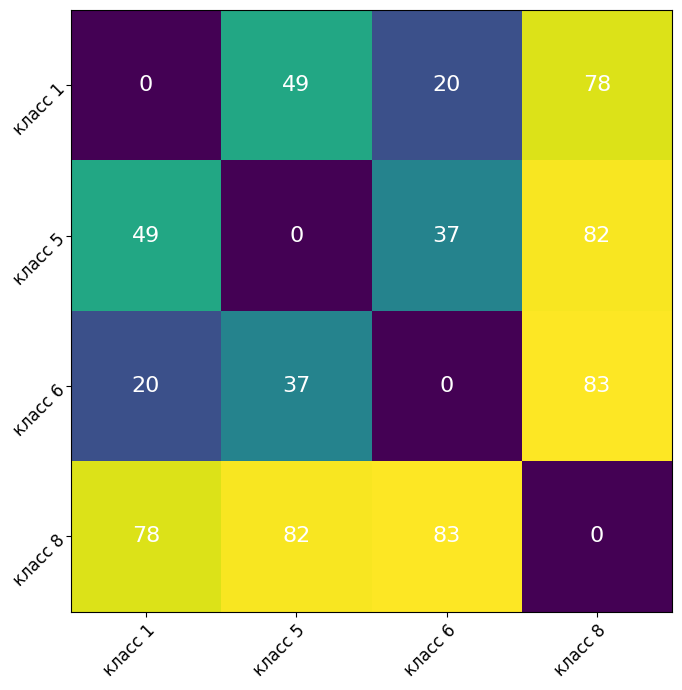


class_power 2.1827706922513648 класс 5


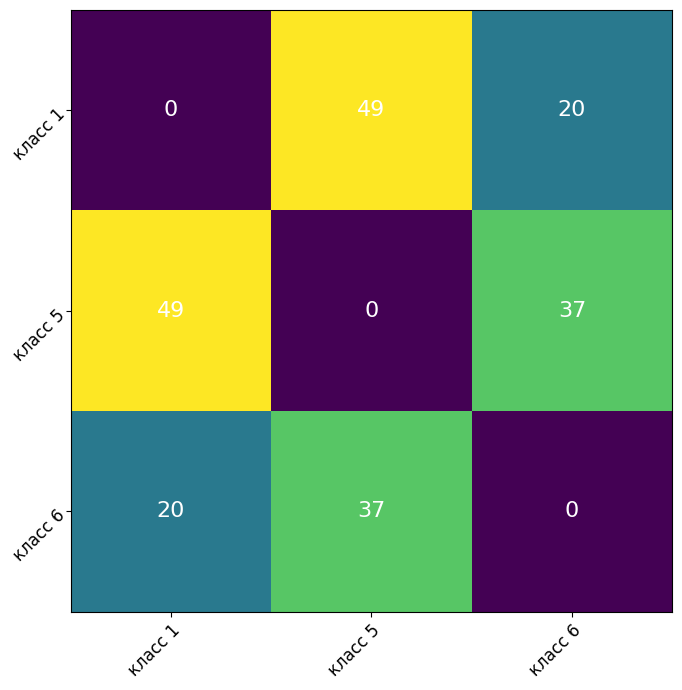


class_power 0 класс 6


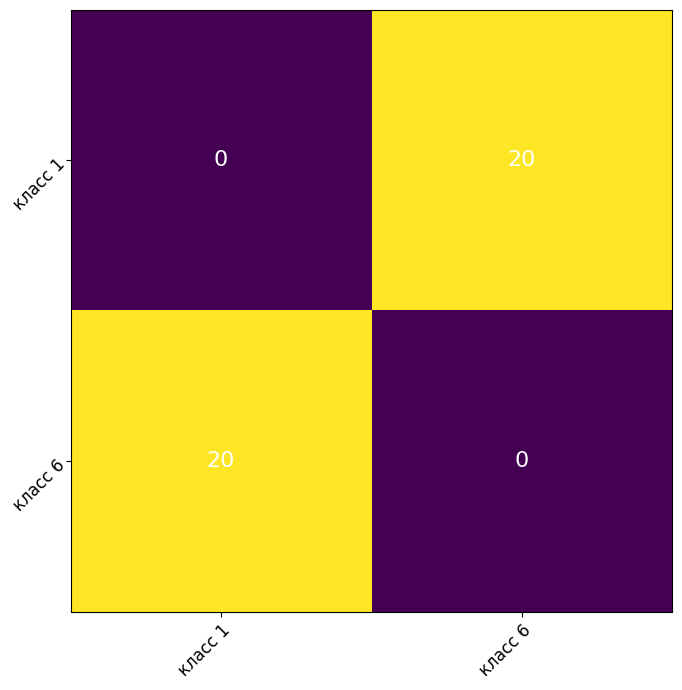

name класс 3
imf_data.shape (145, 145, 350)
n_class 2
reference (350,)
min_class_corr 68.52459719608751


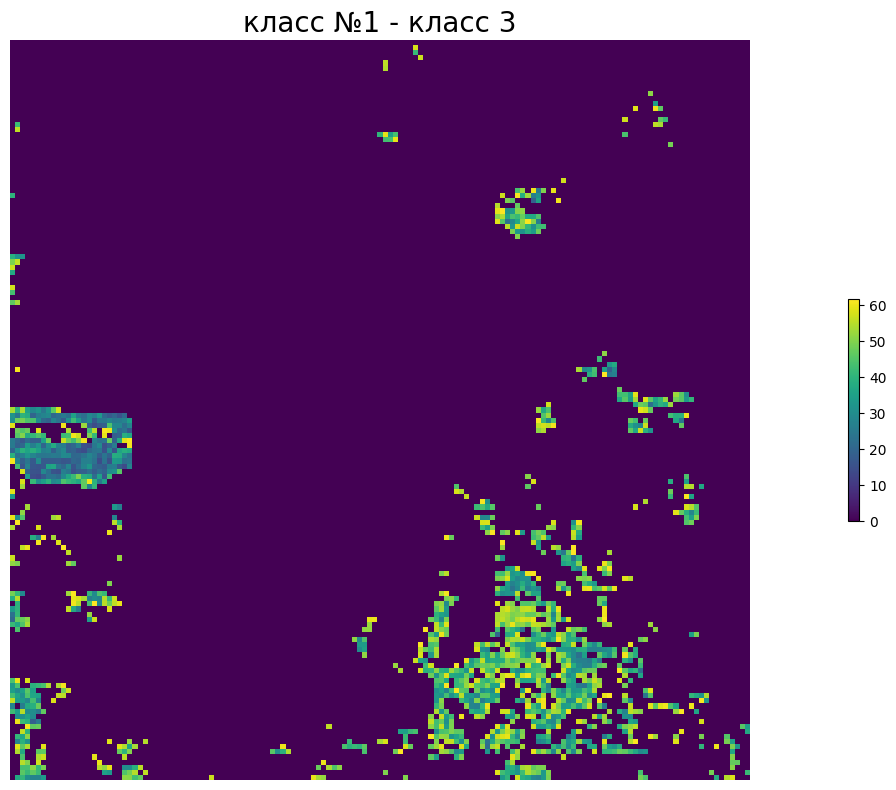



name класс 2
imf_data.shape (145, 145, 350)
n_class 1
reference (350,)
min_class_corr 185.2336246501587


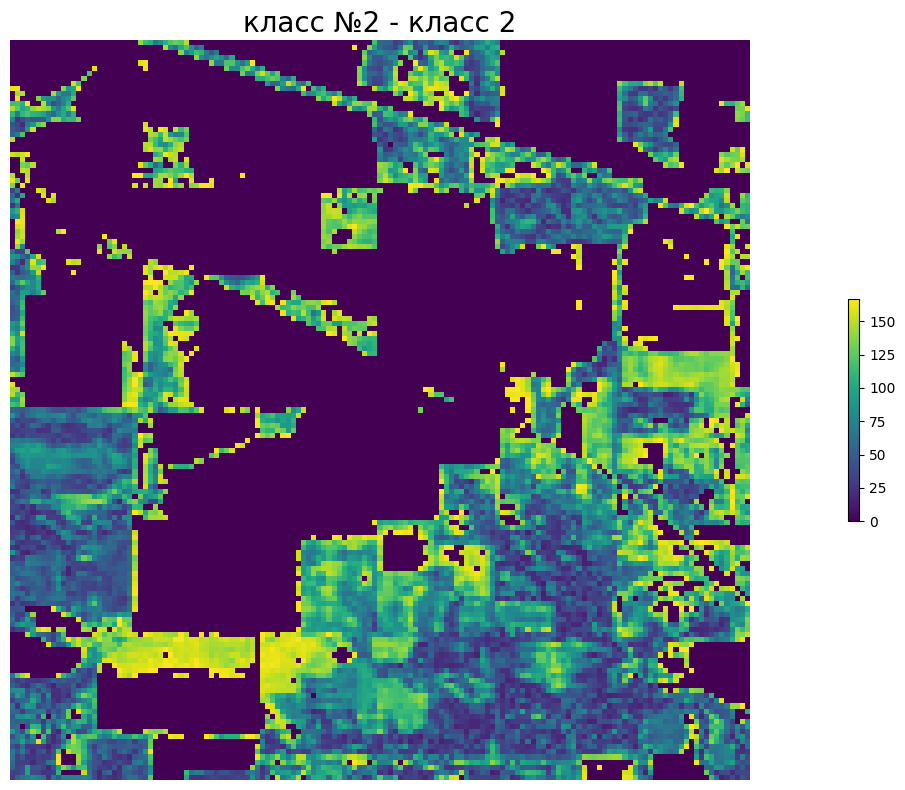



name класс 4
imf_data.shape (145, 145, 350)
n_class 3
reference (350,)
min_class_corr 103.81197951088801


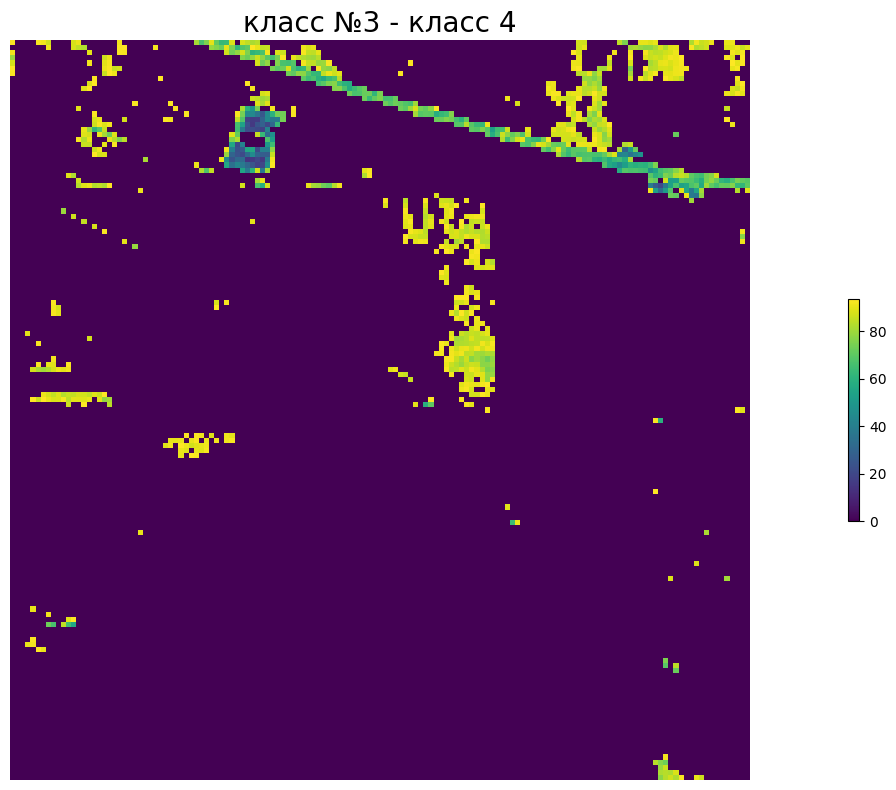



name класс 7
imf_data.shape (145, 145, 350)
n_class 6
reference (350,)
min_class_corr 64.21918979227623


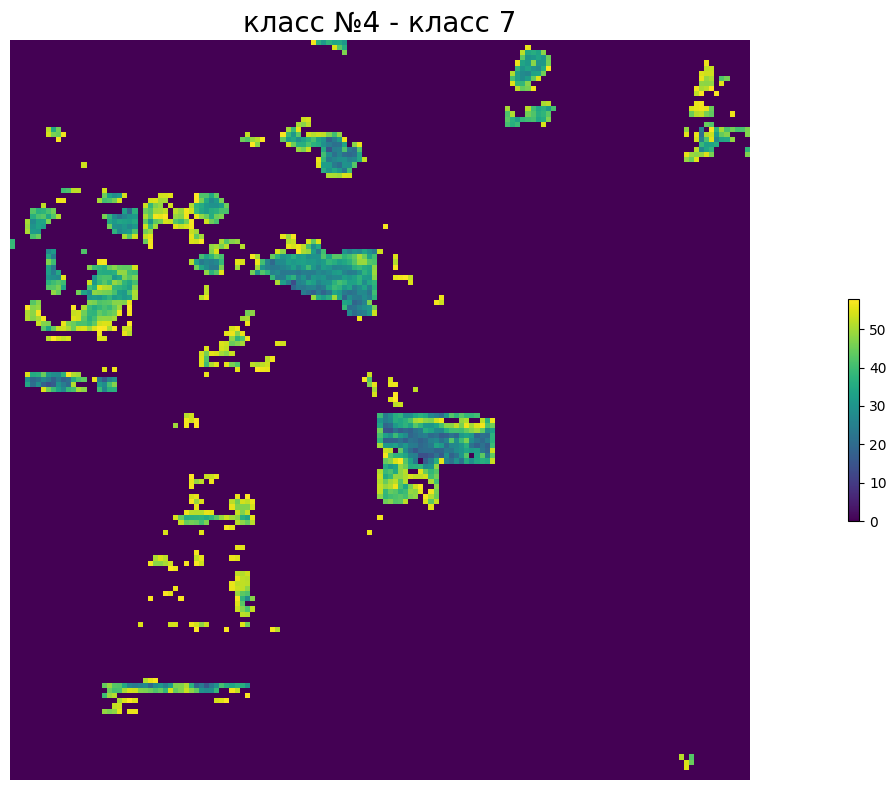



name класс 8
imf_data.shape (145, 145, 350)
n_class 7
reference (350,)
min_class_corr 78.8376741768732


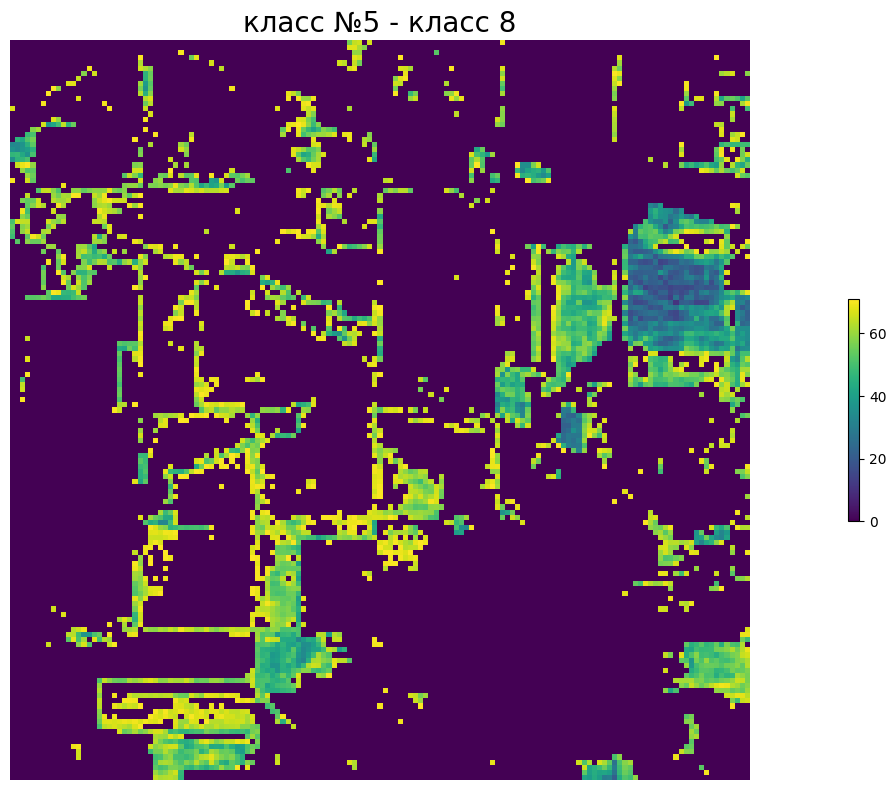



name класс 5
imf_data.shape (145, 145, 350)
n_class 4
reference (350,)
min_class_corr 37.06071559565945


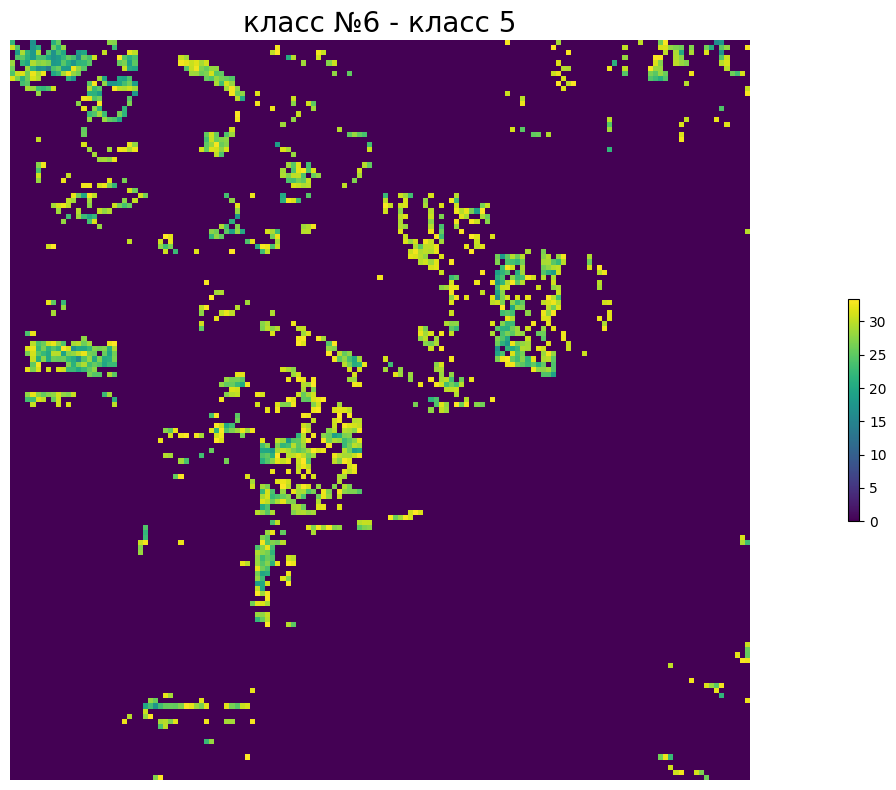



name класс 6
imf_data.shape (145, 145, 350)
n_class 5
reference (350,)
min_class_corr 20.1601432710049


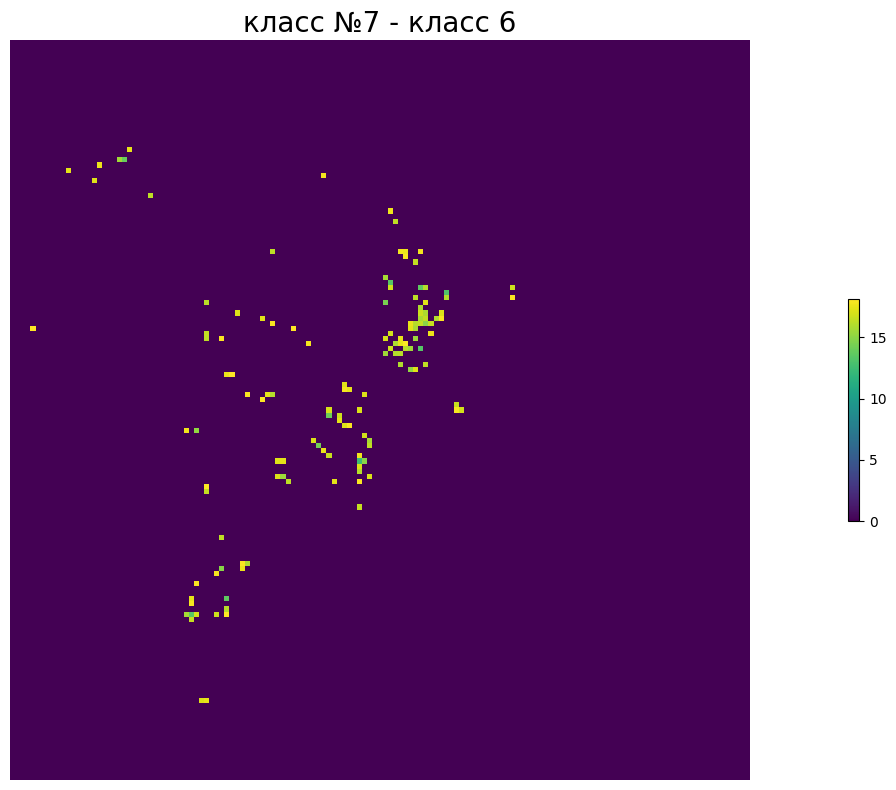



name класс 1
imf_data.shape (145, 145, 350)
n_class 0
reference (350,)
min_class_corr 20.1601432710049


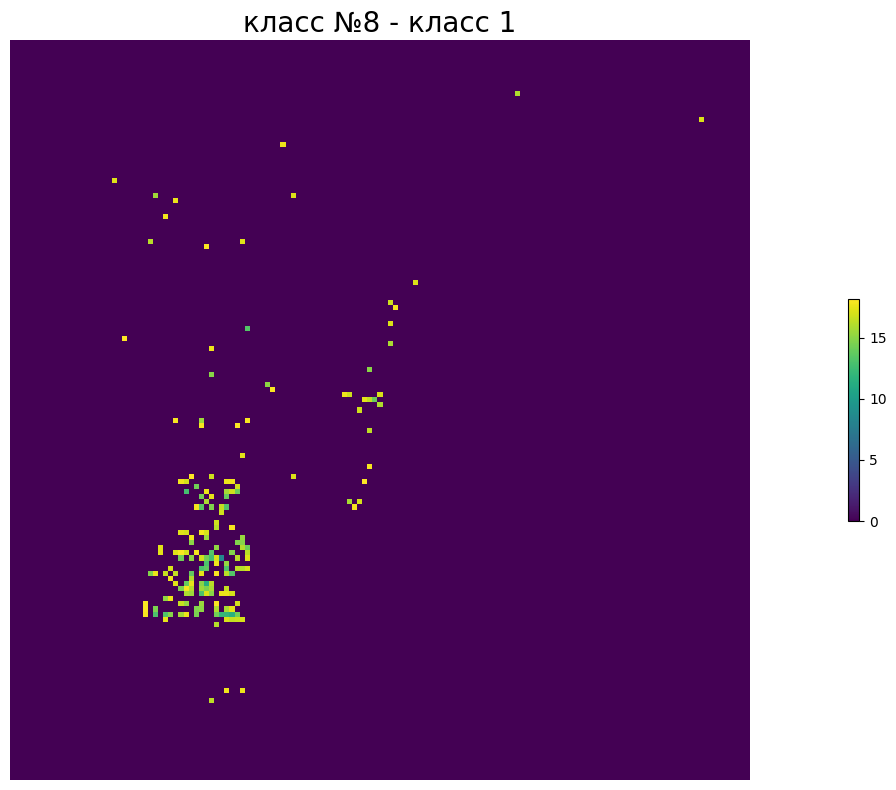

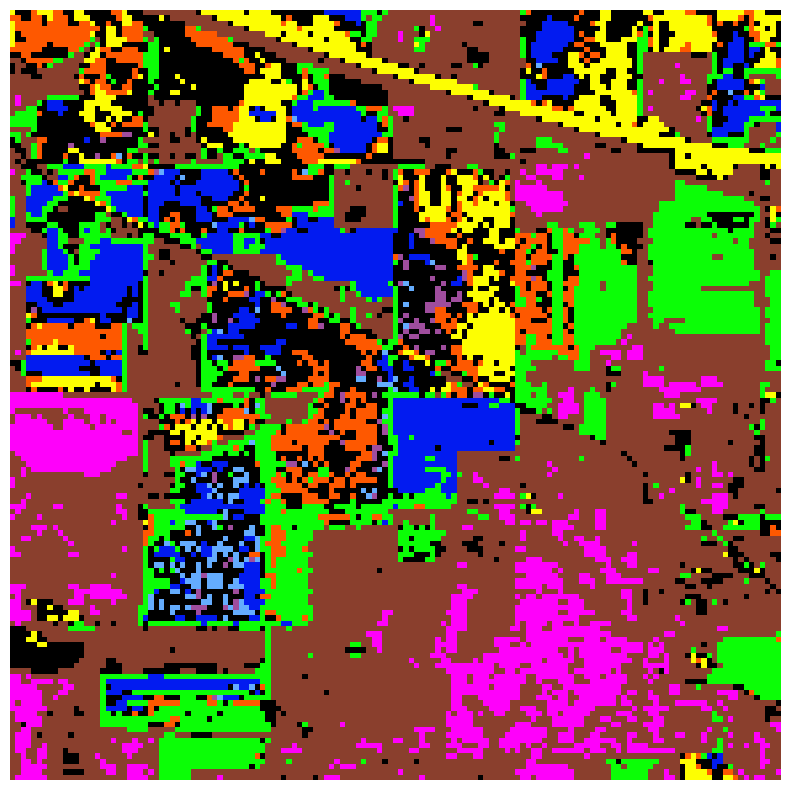

In [81]:
class_mask, color_class = do_all(imf_con_src_data, imf_con_src_reference, name_reference_ru, colors_class, delta = 0.9, path = None, m = 'e')

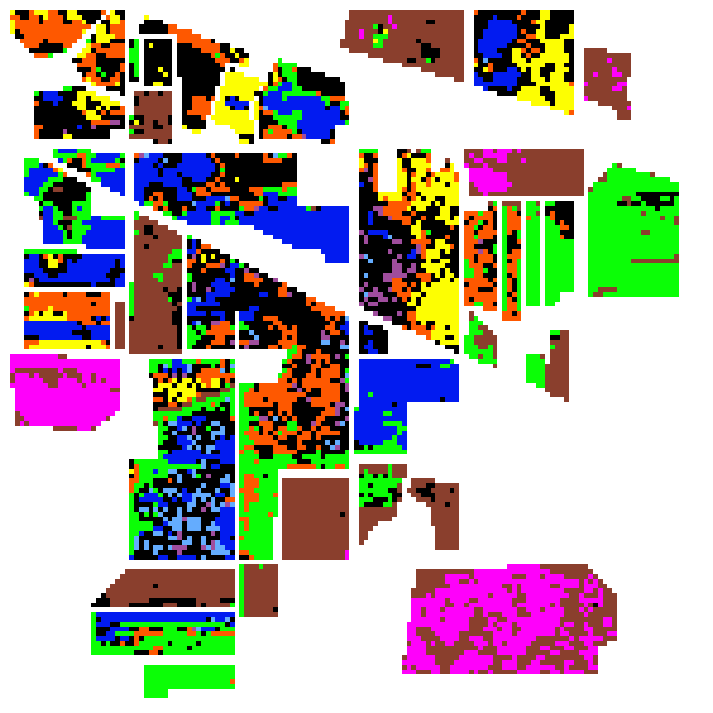

In [82]:
color_class[mask == 0] = 255
hl.show(color_class, figsize = (9, 9))

# imf + imf

In [131]:
imf_n1 = 2
imf_n2 = 3

s1 = imf_reference[imf_n1].copy()
s2 = imf_reference[imf_n2].copy()

norm_s2 = np.zeros(shape = s2.shape, dtype = float)
norm_value_s2 = np.linalg.norm(s1, axis = 1) / np.linalg.norm(s2, axis = 1)

for i in range(s1.shape[0]):
    norm_s2[i] = s2[i] * norm_value_s2[i]

imf_con_imf_ref = np.concatenate((s1, norm_s2), axis = 1)
imf_con_imf_ref.shape

(8, 350)

In [132]:
s1 = imfs[imf_n1]
s2 = imfs[imf_n2]

norm_s1 = np.linalg.norm(s1, axis = 2)
norm_s2 = np.linalg.norm(s2, axis = 2)

imf_con_imf_data = np.zeros(shape = (height, width, bands * 2))

for h in range(height):
    for w in range(width):
        imf_con_imf_data[h, w, bands*0:bands*1] = s1[h, w]
        imf_con_imf_data[h, w, bands*1:bands*2] = s2[h, w] * (norm_s1[h, w] / norm_s2[h, w])
        
    if h % 100 == 0:
        print('\r', end = '')
        print(h, end = '')
        
imf_con_imf_data = np.nan_to_num(imf_con_imf_data, 0)

100


class_power 1.9248361789355881 класс 3


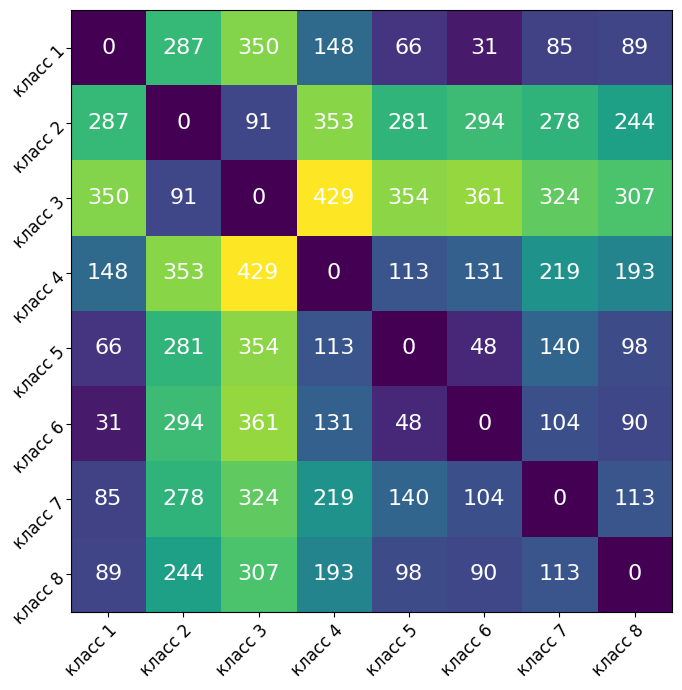


class_power 2.5308651989137037 класс 2


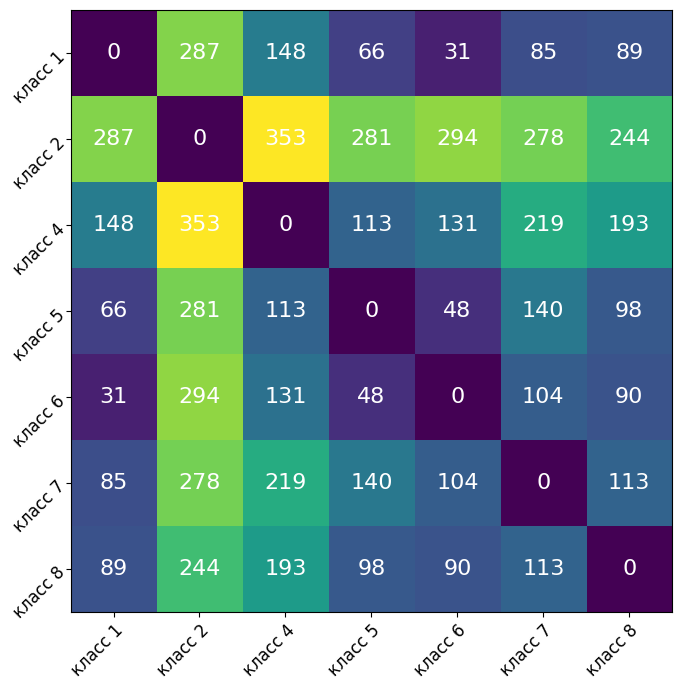


class_power 1.873755204910648 класс 4


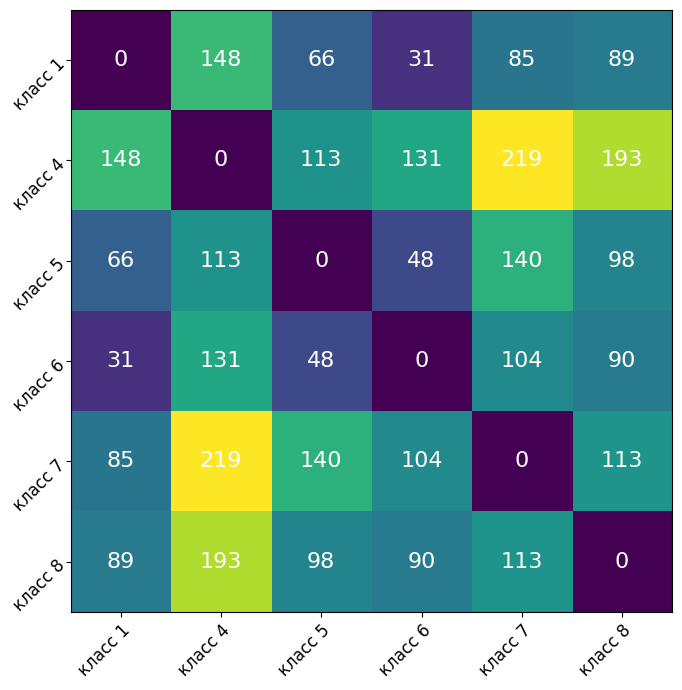


class_power 1.5616822376792208 класс 7


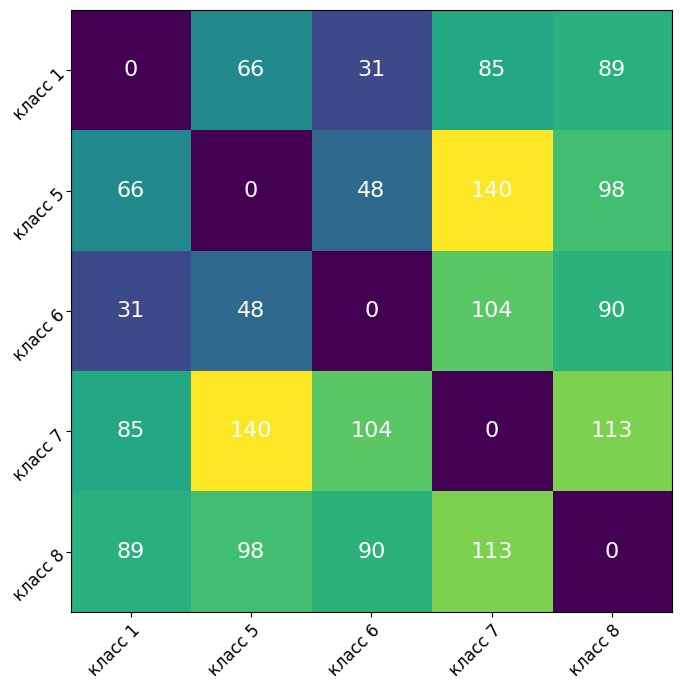


class_power 1.8843168787517388 класс 8


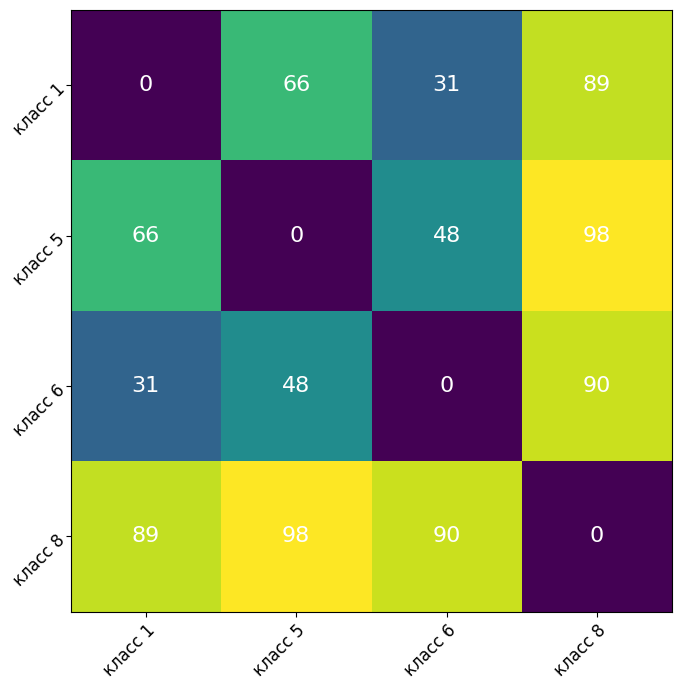


class_power 1.8420800270025957 класс 5


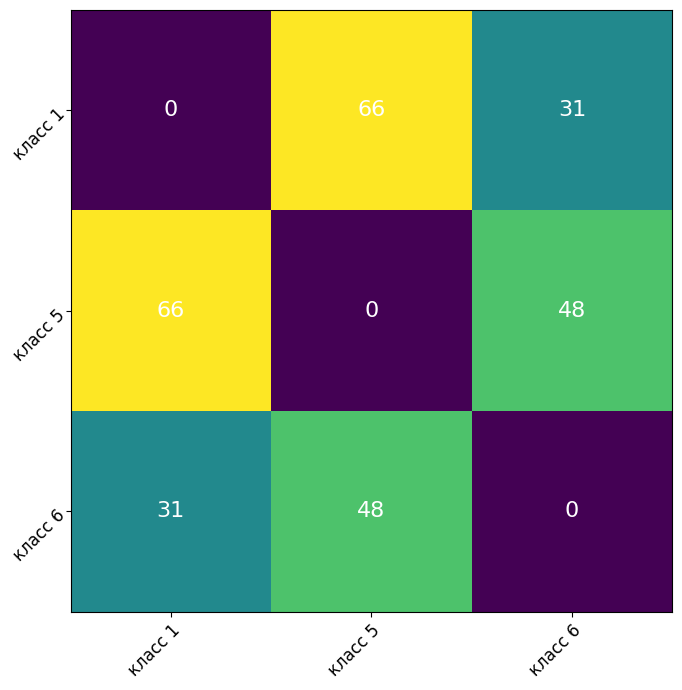


class_power 0 класс 6


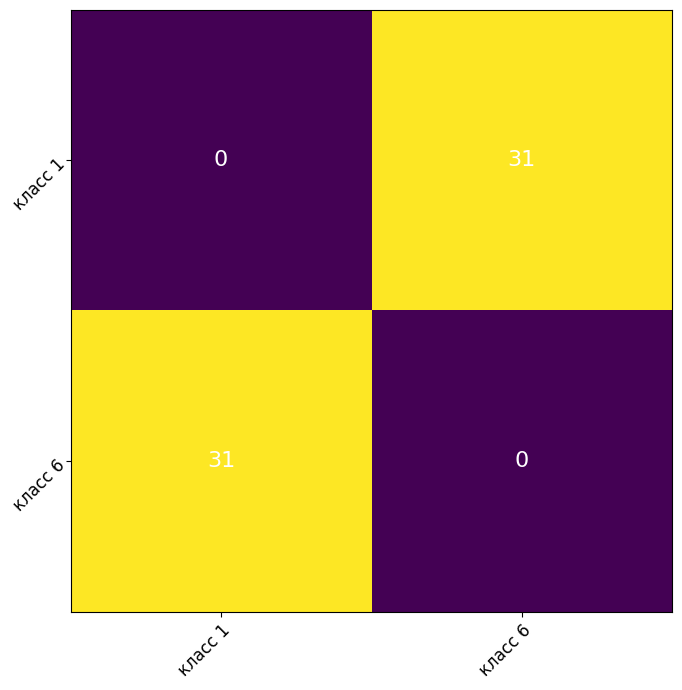

name класс 3
imf_data.shape (145, 145, 350)
n_class 2
reference (350,)
min_class_corr 91.34383495685866


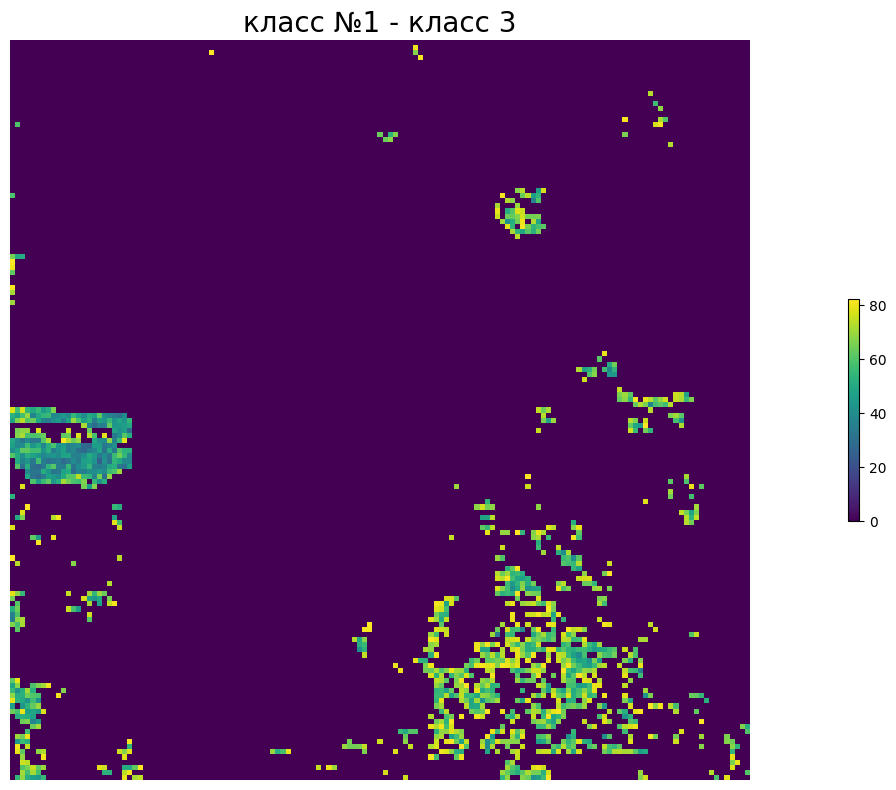



name класс 2
imf_data.shape (145, 145, 350)
n_class 1
reference (350,)
min_class_corr 244.88624188286198


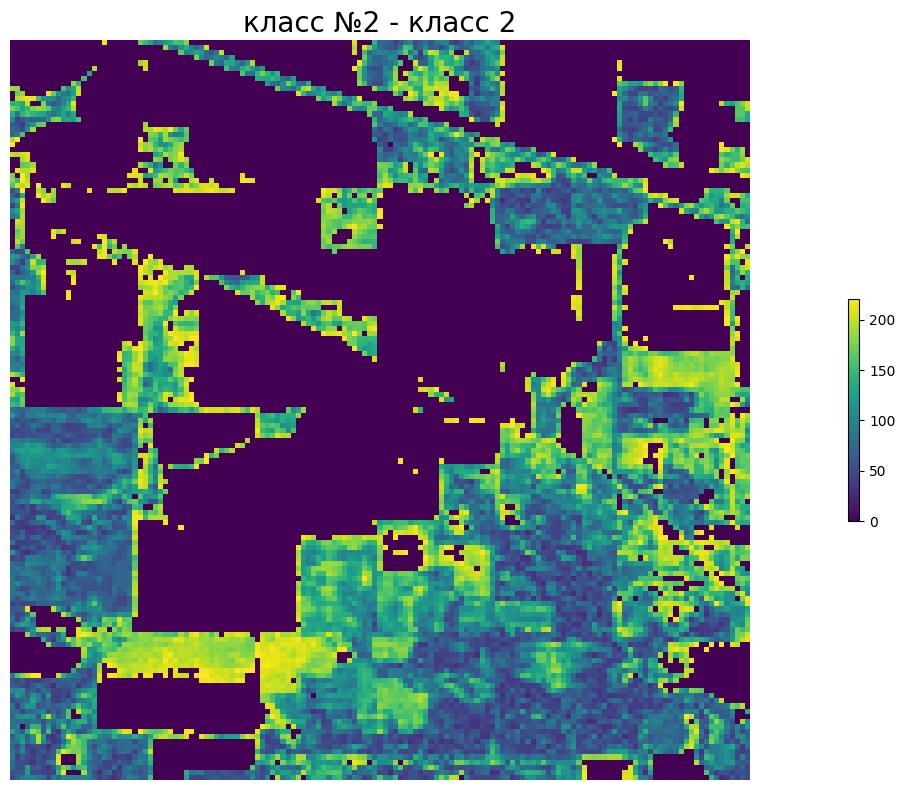



name класс 4
imf_data.shape (145, 145, 350)
n_class 3
reference (350,)
min_class_corr 113.02964533113214


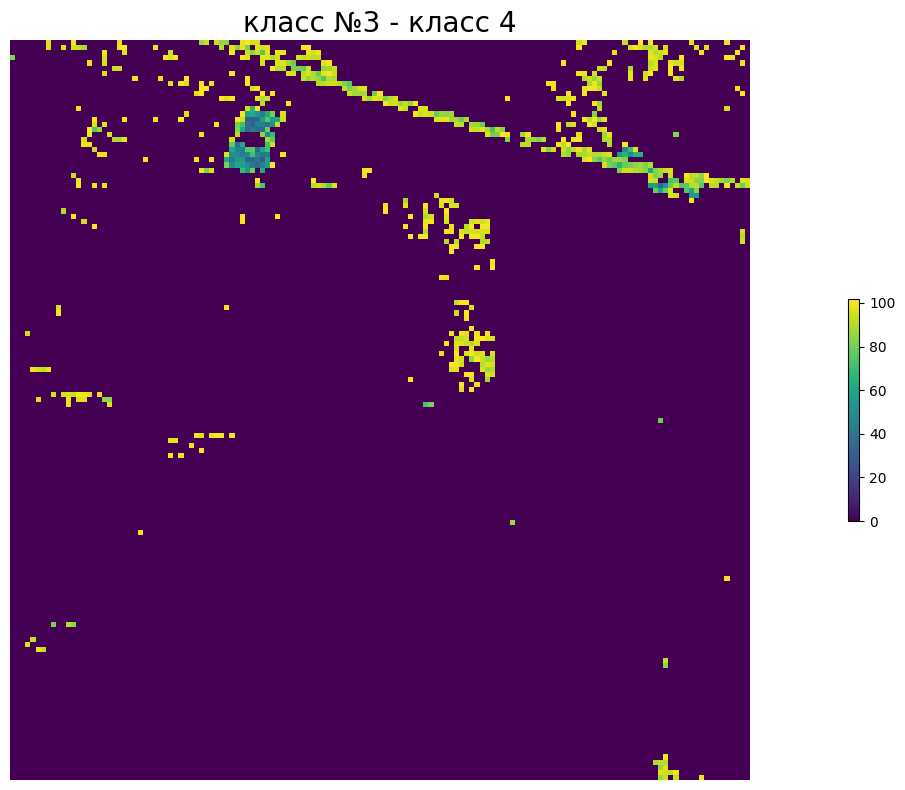



name класс 7
imf_data.shape (145, 145, 350)
n_class 6
reference (350,)
min_class_corr 85.14272799052856


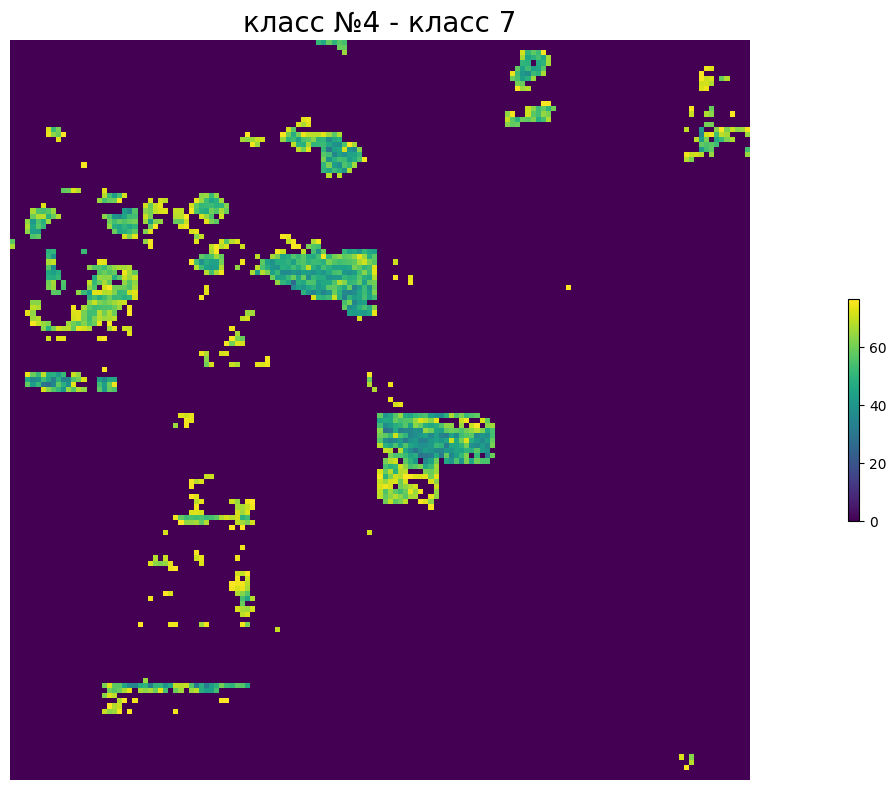



name класс 8
imf_data.shape (145, 145, 350)
n_class 7
reference (350,)
min_class_corr 89.55595728850288


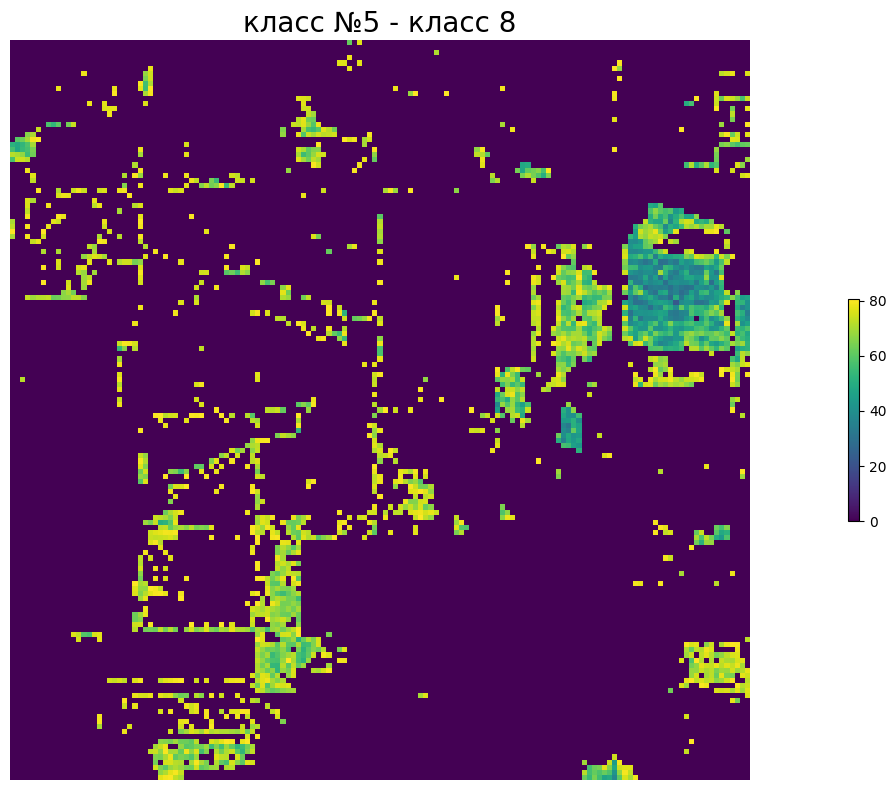



name класс 5
imf_data.shape (145, 145, 350)
n_class 4
reference (350,)
min_class_corr 48.08166240075194


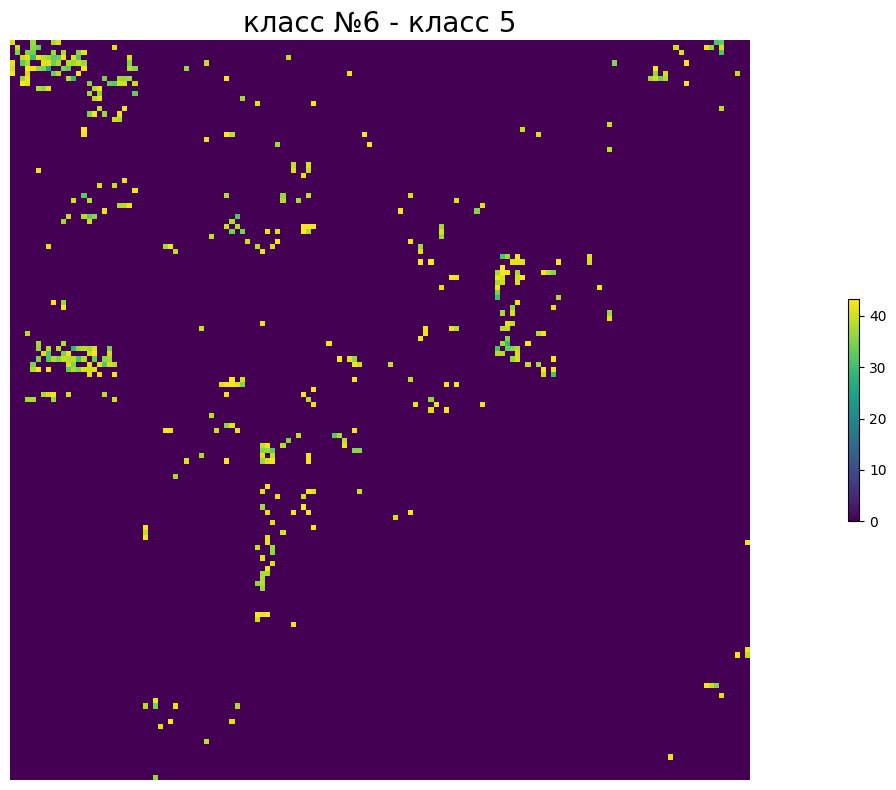



name класс 6
imf_data.shape (145, 145, 350)
n_class 5
reference (350,)
min_class_corr 31.618297180202543


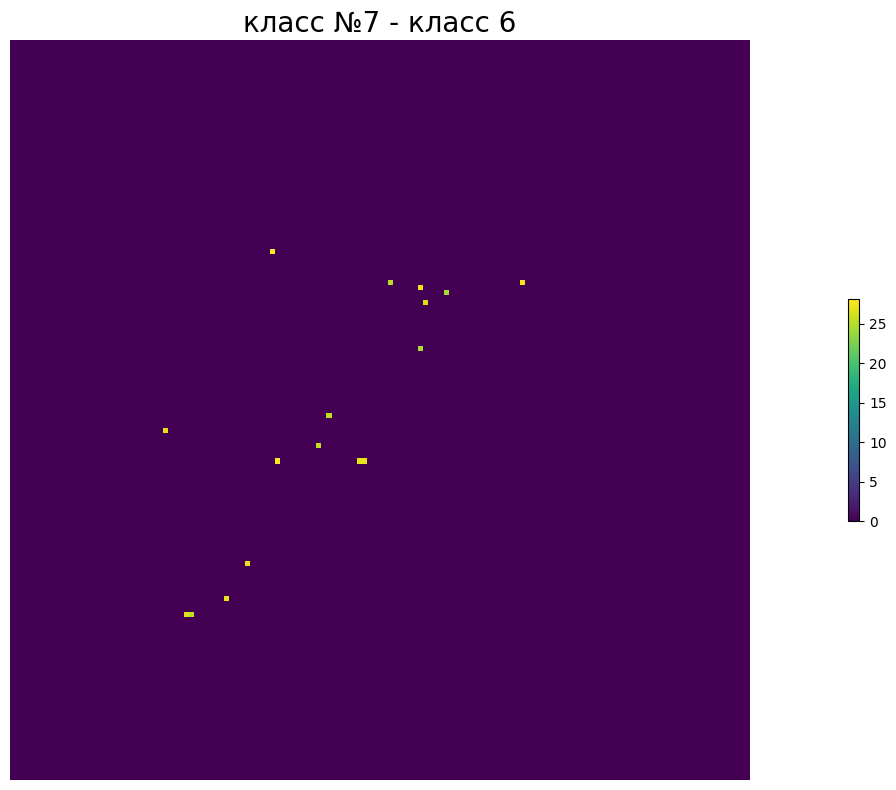



name класс 1
imf_data.shape (145, 145, 350)
n_class 0
reference (350,)
min_class_corr 31.618297180202543


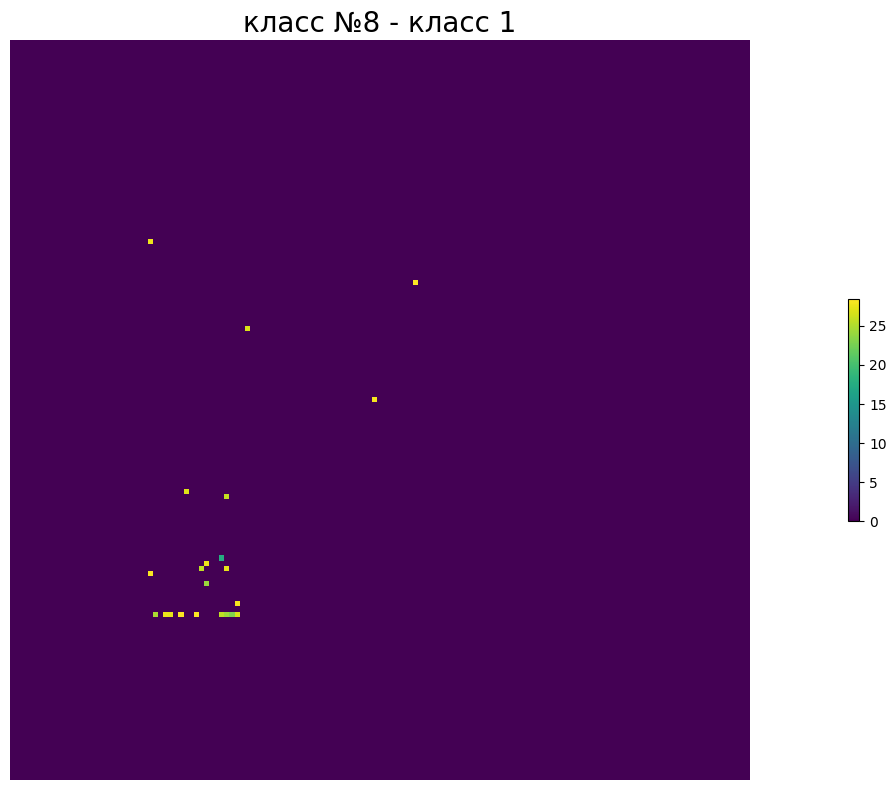

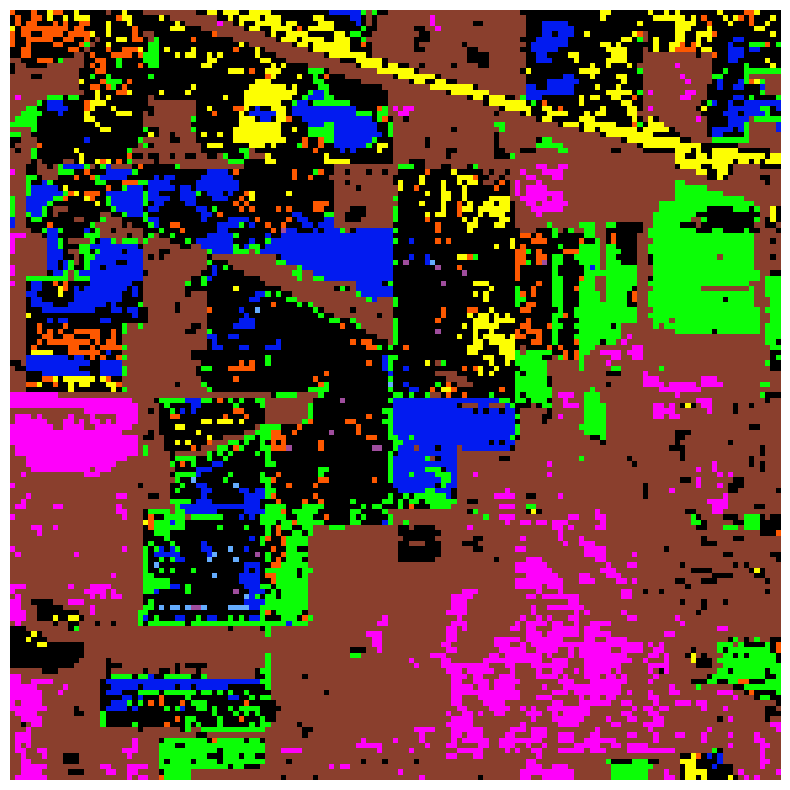

In [133]:
class_mask, color_class = do_all(imf_con_imf_data, imf_con_imf_ref, name_reference_ru, colors_class, delta = 0.9, path = None, m = 'e')

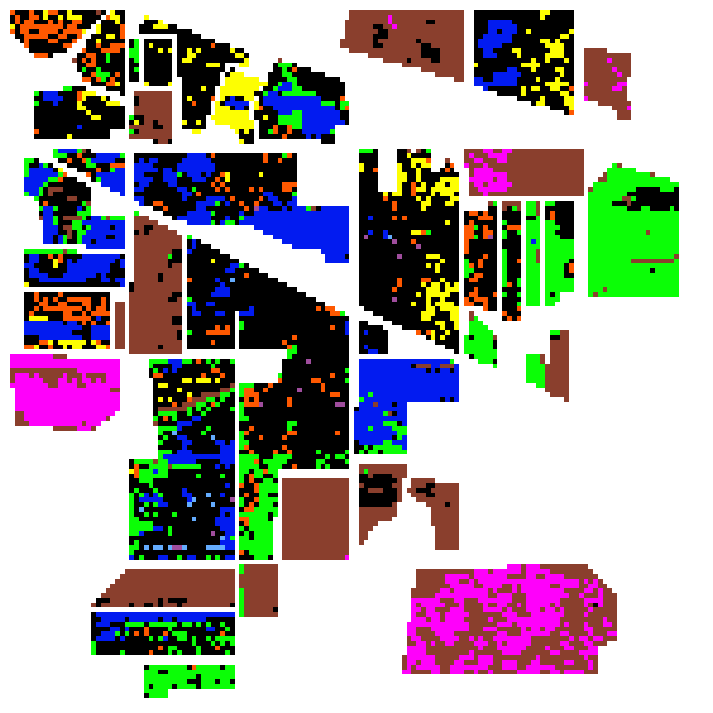

In [134]:
color_class[mask == 0] = 255
hl.show(color_class, figsize = (9, 9))